# Packages

In [1]:
%%capture

# konlpy on colab
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
# kerastuner
!pip install keras-tuner
# Pororo for summarization
!pip install pororo

In [2]:
%%capture

# ÏΩîÎû© ÌïúÍ∏Ä Ìè∞Ìä∏ Íπ®Ïßê Î∞©ÏßÄ
# Ïã§Ìñâ ÌõÑ Îü∞ÌÉÄÏûÑ Îã§Ïãú ÏãúÏûë ÌïÑÏöî
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [9]:
import os
import random
import re
import requests
import time
import pickle

import pandas as pd
import numpy as np
from collections import Counter

from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import IPython
from wordcloud import WordCloud

from konlpy.tag import Mecab
import konlpy
from pororo import Pororo

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.externals import joblib

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, SpatialDropout1D, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import kerastuner as kt

plt.rc('font', family='NanumBarunGothic') # matplotlib Í∏∞Î≥∏ Ìè∞Ìä∏ ÏÑ§Ï†ï
os.chdir('/content/drive/MyDrive/project#1') # ÏΩîÎû© ÎîîÎ†âÌÜ†Î¶¨ Í∏∞Î≥∏ Í≤ΩÎ°ú ÏàòÏ†ï

# Set seed
random.seed(34)
np.random.seed(34)
os.environ['PYTHONHASHSEED'] = str(34)
os.environ['TF_DETERMINISTIC_OPS'] = str(34)
tf.random.set_seed(34)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Data gathering
Ïó¨Îü¨Í∞úÏùò ÎîîÎ†âÌÜ†Î¶¨Ïóê Î∂ÑÌï†ÎêòÏñ¥ ÏûàÎäî Îç∞Ïù¥ÌÑ∞ Ìï©ÏπòÍ∏∞

In [ ]:
target_dir = 'data/HKIB-20000' # Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎäî ÎîîÎ†âÌÜ†Î¶¨
cat_dirs = ['healths', 'economy', 'science', 'education', 'culture', 'society', 'industry', 'leisure', 'politics'] # ÎßåÎì§ ÎîîÎ†âÌÜ†Î¶¨
cat_prefixes = ['Í±¥Í∞ï', 'Í≤ΩÏ†ú', 'Í≥ºÌïô', 'ÍµêÏú°', 'Î¨∏Ìôî', 'ÏÇ¨Ìöå', 'ÏÇ∞ÏóÖ', 'Ïó¨Í∞Ä', 'Ï†ïÏπò'] # Î¨∏ÏÑú Ïπ¥ÌÖåÍ≥†Î¶¨

files = os.listdir(target_dir)
files
# 03ÎÖÑ, 07ÎÖÑÏóê Î∂ÑÌï†Îêú Ïπ¥ÌÖåÍ≥†Î¶¨Í∞Ä ÏûàÏùå
# 07ÎÖÑÏúºÎ°ú ÏÇ¨Ïö©

['HKIB-20000_001.txt',
 'HKIB-20000_002.txt',
 'HKIB-20000_003.txt',
 'HKIB-20000_004.txt',
 'HKIB-20000_005.txt',
 'hkib20000-cat03-all.categories',
 'hkib20000-cat03-file1.categories',
 'hkib20000-cat03-file2.categories',
 'hkib20000-cat03-file3.categories',
 'hkib20000-cat03-file4.categories',
 'hkib20000-cat03-file5.categories',
 'hkib20000-cat07-file1.categories',
 'hkib20000-cat07-file2.categories',
 'hkib20000-cat07-file3.categories',
 'hkib20000-cat07-file4.categories',
 'hkib20000-cat07-file5.categories',
 'hkib20000-cat07-all.categories']

In [ ]:
# Î∂ÑÌï†ÎêòÏñ¥ ÏûàÎäî .txt ÌååÏùºÏùÑ ÎèåÏïÑÍ∞ÄÎ©¥ÏÑú Ï≤òÎ¶¨
for f in files: 
    if not f.endswith('.txt'):
        continue
    
    # Í∞Å txt ÌååÏùºÏùÑ Ïó¥Ïñ¥Î≥¥Í≥† Ï≤òÎ¶¨
    with open(target_dir + '/' + f) as currfile:
        doc_cnt = 0
        docs = []
        curr_doc = None

        # Í∏∞ÏÇ¨(@DOCUMENT) Îã®ÏúÑÎ°ú ÎÇòÎàÑÏñ¥ docs Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
        for curr_line in currfile:
            if curr_line.startswith('@DOCUMENT'):
                if curr_doc is not None:
                    docs.append(curr_doc)
                curr_doc = curr_line
                doc_cnt = doc_cnt + 1
                continue
            curr_doc = curr_doc + curr_line
        
        # docs Î¶¨Ïä§Ìä∏ ÎÇ¥ Í∏∞ÏÇ¨Ïùò Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÎ•ò
        for doc in docs:
            doc_lines = doc.split('\n')
            doc_no = doc_lines[1][9:]

            doc_cat07 = ''
            for line in doc_lines[:10]:
                if line.startswith("#CAT'07:"): # Í∏∞ÏÇ¨ ÎÇ¥ Ïπ¥ÌÖåÍ≥†Î¶¨Í∞Ä Î™ÖÏãúÎêú Î∂ÄÎ∂Ñ
                    doc_cat07 = line[10:]
                    break

            # Ï£ºÏ†úÎ≥Ñ ÎîîÎ†âÌÜ†Î¶¨ Ï†ïÎ¶¨
            for cat_prefix in cat_prefixes: # ÏÇ¨Ï†ÑÏóê Ï†ïÏùòÌï¥ Îëî Ïπ¥ÌÖåÍ≥†Î¶¨ Î™©Î°ù ['Í±¥Í∞ï', 'Í≤ΩÏ†ú', 'Í≥ºÌïô', 'ÍµêÏú°', 'Î¨∏Ìôî', 'ÏÇ¨Ìöå', 'ÏÇ∞ÏóÖ', 'Ïó¨Í∞Ä', 'Ï†ïÏπò']
                if doc_cat07.startswith(cat_prefix):
                    dir_index = cat_prefixes.index(cat_prefix)
                    break
            
            # Í∏∞ÏÇ¨ Î≥∏Î¨∏Îßå Ï∂îÏ∂úÌï¥ÏÑú ÎîîÎ†âÌÜ†Î¶¨ Î≥ÑÎ°ú Ï†ïÎ¶¨
            filtered_lines = []
            for line in doc_lines:
                if not (line.startswith('#') or line.startswith('@')):
                    filtered_lines.append(line)
            
            filename = 'hkib-' + doc_no + '.txt'
            filepath = target_dir + '/' + cat_dirs[dir_index]

            if not os.path.exists(filepath):
                os.makedirs(filepath)

            f = open(filepath + '/' + filename, 'w')
            f.write('\n'.join(filtered_lines))
            f.close()

In [ ]:
# Ïπ¥ÌÖåÍ≥†Î¶¨ Î≥Ñ ÎîîÎ†âÌÜ†Î¶¨Ïóê Îã¥Í∏¥ Î¨∏ÏÑúÎ•º ÏùΩÍ≥† Î∞òÌôòÌïòÎäî Ìï®Ïàò
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        doc = f.read()
        return doc

In [ ]:
categories = []
docs = []

for cat in cat_dirs:
    dir_path = f'data/HKIB-20000/{cat}'
    
    for filename in os.listdir(dir_path):
        docs.append(read_text_file(dir_path + '/' + filename))
        categories.append(cat)

In [ ]:
len(docs), len(categories)

In [ ]:
# ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú ÏÉùÏÑ±
data = pd.DataFrame(columns=['document', 'category'])
data['document'] = docs
data['category'] = categories

data.head(10)

In [ ]:
# Îç∞Ïù¥ÌÑ∞ shuffle
data = data.sample(frac=1).reset_index(drop='index')
data.head(10)

In [ ]:
data.to_csv('data.csv', index_label=False)

# Data(.csv) load

In [13]:
data = pd.read_csv('data.csv')
print(data.shape)
data.head()

(18784, 2)


document category
0   Ïó¨ÏÑ± ÌäπÏú†Ïùò Í∞êÏÑ±ÏÑ∏Í≥ÑÎ•º Í∑∏Î¶¨Í±∞ÎÇò ÏÑ±Ï∞®Î≥ÑÏùÑ Í≥†Î∞úÌïòÎäî ÎÇ¥Ïö©ÏùÑ Îã¥ÏùÄ Ïó¨ÏÑ±\n   Ï∑®Ìñ• ...  culture
1  ÌäπÎ≥ÑÍ≤ÄÏÇ¨Ïóê Í∞ïÏõêÏùº-ÏµúÎ≥ëÎ™®\n<!-search 199910070941:hk:10:::...  society
2   ÏÉàÌï¥Îì§Ïñ¥ Ï£ºÏãùÏãúÏû•Ïùò Í∏∞Í¥ÄÏû•ÏÑ∏ÌôîÍ∞Ä ÎçîÏö± Ïã¨ÌôîÎêòÍ≥† ÏûàÎäî Í≤ÉÏúºÎ°ú ÎÇòÌÉÄÎÇ¨Îã§.\n     ...  economy
3   Ï†ïÎ∂ÄÎäî 8Ïùº Ïò§Ï†Ñ Ïù¥ÌöåÏ∞ΩÏ¥ùÎ¶¨ Ï£ºÏû¨Î°ú Íµ≠Î¨¥ÌöåÏùòÎ•º Ïó¥Í≥† Ïö∞Î£®Í≥ºÏù¥ÎùºÏö¥Îìú(UR)\n   ...  economy
4   ÏÑúÏö∏Í≥º Î∂ÄÏÇ∞ÏßÄÌïòÏ≤†ÎÖ∏Ï°∞Í∞Ä 23Ïùº Ïò§Ï†ÑÎ∂ÄÌÑ∞ Ï§ÄÎ≤ïÏö¥Ìñâ(Í∑úÏ†ïÏ§ÄÏàòÏö¥Ìñâ)Ïóê\n   Îì§Ïñ¥Í∞Ñ Í∞Ä...  society

In [ ]:
# ÌïúÍµ≠Ïñ¥ Î∂àÏö©Ïñ¥ ÏÇ¨Ï†Ñ ÏÉùÏÑ±
stop_words = pd.read_csv('ÌïúÍµ≠Ïñ¥Î∂àÏö©Ïñ¥100.txt', sep='\t', header=None)
stop_words = stop_words[0].tolist()
add_stop_words = ['ÏóêÏÑú', 'Ïùò', 'ÏùÑ', 'Î•º', 'Ïù¥', 'Í∞Ä', 'Îäî', 'ÏùÄ', 'search']

for word in add_stop_words:
    stop_words.append(word)

stop_words = list(set(stop_words))

# mecab ÏÇ¨Ï†Ñ
mecab = Mecab()

In [ ]:
def text_preprocessing(text):
    txt = re.sub('[^Í∞Ä-Ìû£a-zA-Z ]', '', text)
    txt = re.sub('[ ]+', ' ', txt)
    # txt = re.sub('[search,hk]', '', txt)
    return txt

def text_to_morphs(text, tokenizer):
    morphs = tokenizer.morphs(text)
    tokens = [m for m in morphs if m not in stop_words]
    return tokens

In [ ]:
data['doc_clean'] = data['document'].apply(text_preprocessing)

In [ ]:
%%time

data['tokens'] = data['doc_clean'].apply(lambda x: text_to_morphs(x, mecab))

CPU times: user 46.1 s, sys: 268 ms, total: 46.4 s
Wall time: 46.2 s


In [ ]:
data.head()

document  ...                                             tokens
0   Ïó¨ÏÑ± ÌäπÏú†Ïùò Í∞êÏÑ±ÏÑ∏Í≥ÑÎ•º Í∑∏Î¶¨Í±∞ÎÇò ÏÑ±Ï∞®Î≥ÑÏùÑ Í≥†Î∞úÌïòÎäî ÎÇ¥Ïö©ÏùÑ Îã¥ÏùÄ Ïó¨ÏÑ±\n   Ï∑®Ìñ• ...  ...  [Ïó¨ÏÑ±, ÌäπÏú†, Í∞êÏÑ±, ÏÑ∏Í≥Ñ, Í∑∏Î¶¨, Í±∞ÎÇò, ÏÑ±, Ï∞®Î≥Ñ, Í≥†Î∞ú, ÎÇ¥Ïö©, Îã¥, Ïó¨ÏÑ±,...
1  ÌäπÎ≥ÑÍ≤ÄÏÇ¨Ïóê Í∞ïÏõêÏùº-ÏµúÎ≥ëÎ™®\n<!-search 199910070941:hk:10:::...  ...  [ÌäπÎ≥Ñ, Í≤ÄÏÇ¨, Ïóê, Í∞ïÏõêÏùº, ÏµúÎ≥ëÎ™®, ÍπÄ, ÎåÄÌÜµÎ†π, ÏûÑÎ™Ö, ÏùºÌõÑ, Î≥∏Í≤©, ÏàòÏÇ¨, ...
2   ÏÉàÌï¥Îì§Ïñ¥ Ï£ºÏãùÏãúÏû•Ïùò Í∏∞Í¥ÄÏû•ÏÑ∏ÌôîÍ∞Ä ÎçîÏö± Ïã¨ÌôîÎêòÍ≥† ÏûàÎäî Í≤ÉÏúºÎ°ú ÎÇòÌÉÄÎÇ¨Îã§.\n     ...  ...  [ÏÉàÌï¥, Ïñ¥, Ï£ºÏãù, ÏãúÏû•, Í∏∞Í¥ÄÏû•, ÏÑ∏Ìôî, ÎçîÏö±, Ïã¨Ìôî, Í≥†, ÏúºÎ°ú, ÎÇòÌÉÄÎÇ¨, Îã§...
3   Ï†ïÎ∂ÄÎäî 8Ïùº Ïò§Ï†Ñ Ïù¥ÌöåÏ∞ΩÏ¥ùÎ¶¨ Ï£ºÏû¨Î°ú Íµ≠Î¨¥ÌöåÏùòÎ•º Ïó¥Í≥† Ïö∞Î£®Í≥ºÏù¥ÎùºÏö¥Îìú(UR)\n   ...  ...  [Ï†ïÎ∂Ä, Ïò§Ï†Ñ, Ïù¥ÌöåÏ∞Ω, Ï¥ùÎ¶¨, Ï£ºÏû¨, Î°ú, Íµ≠Î¨¥, ÌöåÏùò, Ïó¥, Í≥†, Ïö∞Î£®Í≥ºÏù¥, Îùº...
4   ÏÑúÏö∏Í≥º Î∂ÄÏÇ∞ÏßÄÌïòÏ≤†ÎÖ∏Ï°∞Í∞Ä 23Ïùº Ïò§Ï†ÑÎ∂ÄÌÑ∞ Ï§ÄÎ≤ïÏö¥Ìñâ(Í∑úÏ†ïÏ§ÄÏàòÏö¥Ìñâ)Ïóê\n   Îì§Ïñ¥Í∞Ñ Í∞Ä...  ...  [ÏÑúÏö∏, Í≥º, Î∂ÄÏÇ∞, ÏßÄÌïòÏ≤†, ÎÖ∏Ï°∞, Ïò§Ï†Ñ, Î∂ÄÌÑ∞, Ï§ÄÎ≤ï, Ïö¥Ìñâ, Í∑úÏ†ï, Ï§ÄÏàò, Ïö¥...

[5 rows x 4 columns]

# EDA

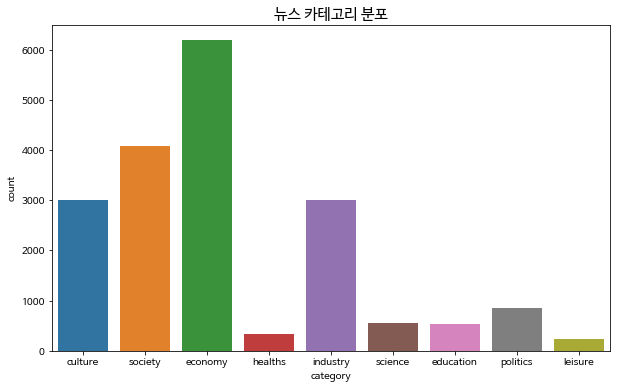

economy      6188
society      4071
culture      3008
industry     2996
politics      860
science       548
education     540
healths       331
leisure       242
Name: category, dtype: int64


In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=data['category'])
plt.title('Îâ¥Ïä§ Ïπ¥ÌÖåÍ≥†Î¶¨ Î∂ÑÌè¨', size=15)
plt.show();

print(data['category'].value_counts())

üî•üî•üî• 

Ïπ¥ÌÖåÍ≥†Î¶¨Í∞Ä ÏÉÅÎãπÌûà Î∂àÍ∑†ÌòïÌï®

Í≤ΩÏ†ú, ÏÇ¨Ìöå, Î¨∏Ìôî, ÏÇ∞ÏóÖ ÏàúÏúºÎ°ú Í∞ÄÏû• ÎßéÏùÄ Í∏∞ÏÇ¨Í∞Ä ÏûàÍ≥†, Ïó¨Í∞Ä, Í±¥Í∞ï, ÍµêÏú° Îì±Ïùò Í∏∞ÏÇ¨Îäî Îß§Ïö∞ Ï†ÅÏùÄ ÏàòÎ•º Î≥¥ÏûÑ

Ïö∞Î¶¨Í∞Ä Í¥ÄÏã¨Î∂ÑÏïºÍ∞Ä ÏïÑÎãå Î¨¥ÏùòÏãù Ï§ëÏóê ÌèâÏÜå Ï†ëÌïòÎäî Í∏∞ÏÇ¨ Ï§ë ÎåÄÎ∂ÄÎ∂ÑÎèÑ Í≤ΩÏ†ú,ÏÇ¨Ìöå,Î¨∏Ìôî Îì±Ïùò Ï£ºÏ†úÏù∏ Í≤ÉÍ≥º Í∞ôÏùÄ Îß•ÎùΩÏúºÎ°ú Î≥º Ïàò ÏûàÏùå

üî•üî•üî• 

Î∂àÍ∑†ÌòïÌïú Ïπ¥ÌÖåÍ≥†Î¶¨Í∞Ä ÌÖçÏä§Ìä∏ Î∂ÑÎ•ò Î¨∏Ï†úÏóêÏÑú ÌÅ∞ Î¨∏Ï†úÍ∞Ä ÏóÜÏùÑ ÏßÄ Ï°∞ÏÇ¨Í∞Ä ÌïÑÏöî

==> ImbalancedÌïú Îç∞Ïù¥ÌÑ∞Î•º Îã§Î£®Í∏∞ ÏúÑÌïú Ïó¨Îü¨Í∞ÄÏßÄ Î∞©Î≤ïÏù¥ ÏûàÏùå. ÏùºÎã® ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Î°ú ÌååÏù¥ÌîÑÎùºÏù∏ÏùÑ Íµ¨Ï∂ïÌï¥Î≥¥Í≥† Resampling, SMOTE Îì±Ïùò Î∞©Î≤ïÏùÑ Ï†ÅÏö©Ìïú ÌõÑÏóê ÎπÑÍµêÌï¥ Î≥º Í≤É

üî•üî•üî• 

ÎÑàÎ¨¥ Ï†ÅÏùÄ ÏÉòÌîåÏùÑ Í∞ÄÏßÑ Ïπ¥ÌÖåÍ≥†Î¶¨Î•º Ìï©Ï≥êÏ§Ñ Ïàò ÏûàÏùÑ Í≤É Í∞ôÏùå

> culture + leisure + education => ÏÉùÌôú/Î¨∏Ìôî

> healths + science => Í≥ºÌïô/Í±¥Í∞ï

> politics + society => Ï†ïÏπò/ÏÇ¨Ìöå

> economy + industry => Í≤ΩÏ†ú/ÏÇ∞ÏóÖ





In [ ]:
def category_sum(text):
    if (text=='culture') or (text=='leisure') or (text=='education'):
        text = 'ÏÉùÌôú/Î¨∏Ìôî'

    elif (text=='healths') or (text=='science'):
        text = 'Í≥ºÌïô/Í±¥Í∞ï'
    
    elif (text=='politics') or (text=='society'):
        text = 'Ï†ïÏπò/ÏÇ¨Ìöå'
    
    elif (text=='economy') or (text=='industry'):
        text = 'Í≤ΩÏ†ú/ÏÇ∞ÏóÖ'

    return text

In [ ]:
data['category'] = data['category'].apply(category_sum)
data['category'].unique()

array(['ÏÉùÌôú/Î¨∏Ìôî', 'Ï†ïÏπò/ÏÇ¨Ìöå', 'Í≤ΩÏ†ú/ÏÇ∞ÏóÖ', 'Í≥ºÌïô/Í±¥Í∞ï'], dtype=object)

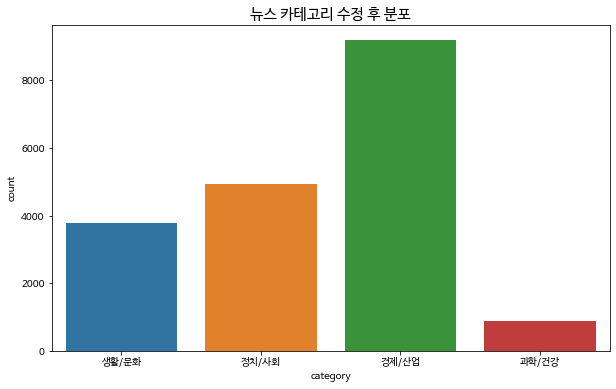

Í≤ΩÏ†ú/ÏÇ∞ÏóÖ    9184
Ï†ïÏπò/ÏÇ¨Ìöå    4931
ÏÉùÌôú/Î¨∏Ìôî    3790
Í≥ºÌïô/Í±¥Í∞ï     879
Name: category, dtype: int64


In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=data['category'])
plt.title('Îâ¥Ïä§ Ïπ¥ÌÖåÍ≥†Î¶¨ ÏàòÏ†ï ÌõÑ Î∂ÑÌè¨', size=15)
plt.show();

print(data['category'].value_counts())

In [ ]:
data.head()

document  ...                                             tokens
0   Ïó¨ÏÑ± ÌäπÏú†Ïùò Í∞êÏÑ±ÏÑ∏Í≥ÑÎ•º Í∑∏Î¶¨Í±∞ÎÇò ÏÑ±Ï∞®Î≥ÑÏùÑ Í≥†Î∞úÌïòÎäî ÎÇ¥Ïö©ÏùÑ Îã¥ÏùÄ Ïó¨ÏÑ±\n   Ï∑®Ìñ• ...  ...  [Ïó¨ÏÑ±, ÌäπÏú†, Í∞êÏÑ±, ÏÑ∏Í≥Ñ, Í∑∏Î¶¨, Í±∞ÎÇò, ÏÑ±, Ï∞®Î≥Ñ, Í≥†Î∞ú, ÎÇ¥Ïö©, Îã¥, Ïó¨ÏÑ±,...
1  ÌäπÎ≥ÑÍ≤ÄÏÇ¨Ïóê Í∞ïÏõêÏùº-ÏµúÎ≥ëÎ™®\n<!-search 199910070941:hk:10:::...  ...  [ÌäπÎ≥Ñ, Í≤ÄÏÇ¨, Ïóê, Í∞ïÏõêÏùº, ÏµúÎ≥ëÎ™®, ÍπÄ, ÎåÄÌÜµÎ†π, ÏûÑÎ™Ö, ÏùºÌõÑ, Î≥∏Í≤©, ÏàòÏÇ¨, ...
2   ÏÉàÌï¥Îì§Ïñ¥ Ï£ºÏãùÏãúÏû•Ïùò Í∏∞Í¥ÄÏû•ÏÑ∏ÌôîÍ∞Ä ÎçîÏö± Ïã¨ÌôîÎêòÍ≥† ÏûàÎäî Í≤ÉÏúºÎ°ú ÎÇòÌÉÄÎÇ¨Îã§.\n     ...  ...  [ÏÉàÌï¥, Ïñ¥, Ï£ºÏãù, ÏãúÏû•, Í∏∞Í¥ÄÏû•, ÏÑ∏Ìôî, ÎçîÏö±, Ïã¨Ìôî, Í≥†, ÏúºÎ°ú, ÎÇòÌÉÄÎÇ¨, Îã§...
3   Ï†ïÎ∂ÄÎäî 8Ïùº Ïò§Ï†Ñ Ïù¥ÌöåÏ∞ΩÏ¥ùÎ¶¨ Ï£ºÏû¨Î°ú Íµ≠Î¨¥ÌöåÏùòÎ•º Ïó¥Í≥† Ïö∞Î£®Í≥ºÏù¥ÎùºÏö¥Îìú(UR)\n   ...  ...  [Ï†ïÎ∂Ä, Ïò§Ï†Ñ, Ïù¥ÌöåÏ∞Ω, Ï¥ùÎ¶¨, Ï£ºÏû¨, Î°ú, Íµ≠Î¨¥, ÌöåÏùò, Ïó¥, Í≥†, Ïö∞Î£®Í≥ºÏù¥, Îùº...
4   ÏÑúÏö∏Í≥º Î∂ÄÏÇ∞ÏßÄÌïòÏ≤†ÎÖ∏Ï°∞Í∞Ä 23Ïùº Ïò§Ï†ÑÎ∂ÄÌÑ∞ Ï§ÄÎ≤ïÏö¥Ìñâ(Í∑úÏ†ïÏ§ÄÏàòÏö¥Ìñâ)Ïóê\n   Îì§Ïñ¥Í∞Ñ Í∞Ä...  ...  [ÏÑúÏö∏, Í≥º, Î∂ÄÏÇ∞, ÏßÄÌïòÏ≤†, ÎÖ∏Ï°∞, Ïò§Ï†Ñ, Î∂ÄÌÑ∞, Ï§ÄÎ≤ï, Ïö¥Ìñâ, Í∑úÏ†ï, Ï§ÄÏàò, Ïö¥...

[5 rows x 4 columns]

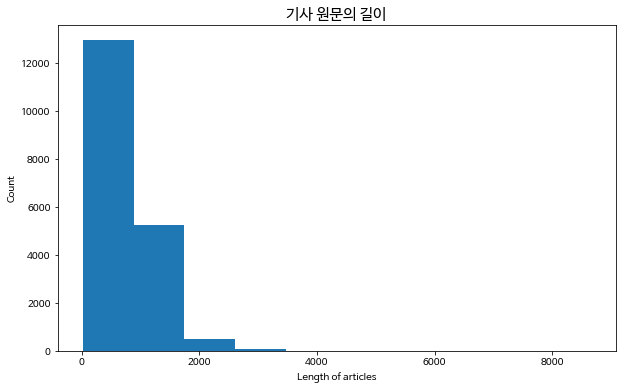

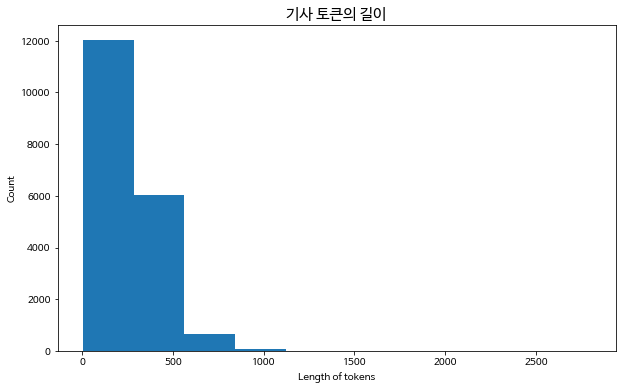

In [ ]:
# Í∏∞ÏÇ¨ ÏõêÎ¨∏Ïùò Í∏∏Ïù¥ Î∂ÑÌè¨
plt.figure(figsize=(10,6))
plt.hist([len(doc) for doc in data['doc_clean']])
plt.title('Í∏∞ÏÇ¨ ÏõêÎ¨∏Ïùò Í∏∏Ïù¥', size=15)
plt.ylabel('Count')
plt.xlabel('Length of articles')
plt.show();

# ÌÜ†ÌÅ∞Ïùò Í∏∏Ïù¥ Î∂ÑÌè¨
plt.figure(figsize=(10, 6))
plt.hist([len(token) for token in data['tokens']])
plt.title('Í∏∞ÏÇ¨ ÌÜ†ÌÅ∞Ïùò Í∏∏Ïù¥', size=15)
plt.ylabel('Count')
plt.xlabel('Length of tokens')
plt.show();

üî•üî•üî• Í∏∞ÏÇ¨ ÏõêÎ¨∏Í≥º ÌòïÌÉúÏÜå ÌÜ†ÌÅ∞ Í∏∏Ïù¥Ïùò Î∂ÑÌè¨Îäî ÌÅ∞ Ï∞®Ïù¥Í∞Ä ÏóÜÏùå

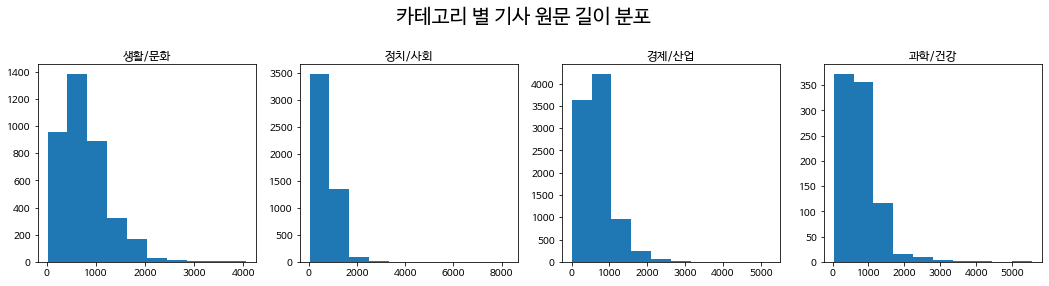

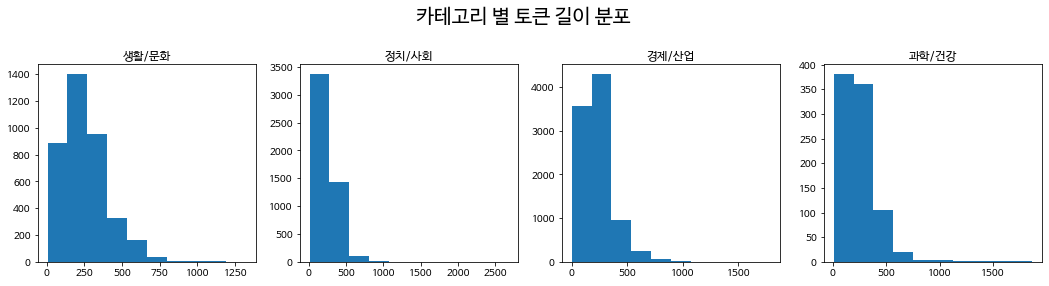

In [ ]:
# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Í∏∞ÏÇ¨ ÏõêÎ¨∏ Í∏∏Ïù¥ Î∂ÑÌè¨
plt.figure(figsize=(18, 8))

plot_location = 1
for category in data['category'].unique().tolist():
    plt.subplot(2, 4, plot_location)
    plt.title(f'{category}')
    plt.hist([len(doc) for doc in data[data['category']==category]['doc_clean']])
    plt.suptitle('Ïπ¥ÌÖåÍ≥†Î¶¨ Î≥Ñ Í∏∞ÏÇ¨ ÏõêÎ¨∏ Í∏∏Ïù¥ Î∂ÑÌè¨', size = 20)
    plot_location += 1
plt.figure(figsize=(18, 8))

# Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌÜ†ÌÅ∞ Í∏∏Ïù¥ Î∂ÑÌè¨
plot_location = 1
for category in data['category'].unique().tolist():
    plt.subplot(2, 4, plot_location)
    plt.title(f'{category}')
    plt.hist([len(token) for token in data[data['category']==category]['tokens']])
    plt.suptitle('Ïπ¥ÌÖåÍ≥†Î¶¨ Î≥Ñ ÌÜ†ÌÅ∞ Í∏∏Ïù¥ Î∂ÑÌè¨', size=20)
    plot_location += 1

In [ ]:
maxlen = max([len(token) for token in data['tokens']])
meanlen = np.mean([len(token) for token in data['tokens']])

maxlen, meanlen

(2677, 240.08970400340715)

üî•üî•üî• 

Ï†ÑÏ≤¥ ÌÜ†ÌÅ∞ Ï§ë ÏµúÎåÄ Í∏∏Ïù¥Îäî 2799Í∞ú, ÌèâÍ∑†ÏùÄ 260Í∞ú

Ï†ÑÏ≤¥ Í∏∞ÏÇ¨Ïùò ÌÜ†ÌÅ∞ÏùÄ ÏïΩ 200~400 Ï†ïÎèÑÏùò Í∏∏Ïù¥ÏûÑÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏùå

In [ ]:
# Ï†ïÏàòÎ°ú Ïù¥Î£®Ïñ¥ÏßÑ ÌÉÄÍ≤ü ÌÅ¥ÎûòÏä§ ÏπºÎüº ÏÉùÏÑ±
categories_lst = data['category'].unique().tolist()

def category_to_num(category):
    for i, j in enumerate(categories_lst):
        if j == category:
            return i

data['class'] = data['category'].apply(category_to_num)

print(categories_lst)
print(data['category'].value_counts())
print(data['class'].value_counts())

['ÏÉùÌôú/Î¨∏Ìôî', 'Ï†ïÏπò/ÏÇ¨Ìöå', 'Í≤ΩÏ†ú/ÏÇ∞ÏóÖ', 'Í≥ºÌïô/Í±¥Í∞ï']
Í≤ΩÏ†ú/ÏÇ∞ÏóÖ    9184
Ï†ïÏπò/ÏÇ¨Ìöå    4931
ÏÉùÌôú/Î¨∏Ìôî    3790
Í≥ºÌïô/Í±¥Í∞ï     879
Name: category, dtype: int64
2    9184
1    4931
0    3790
3     879
Name: class, dtype: int64


In [ ]:
data.head()

document  ... class
0   Ïó¨ÏÑ± ÌäπÏú†Ïùò Í∞êÏÑ±ÏÑ∏Í≥ÑÎ•º Í∑∏Î¶¨Í±∞ÎÇò ÏÑ±Ï∞®Î≥ÑÏùÑ Í≥†Î∞úÌïòÎäî ÎÇ¥Ïö©ÏùÑ Îã¥ÏùÄ Ïó¨ÏÑ±\n   Ï∑®Ìñ• ...  ...     0
1  ÌäπÎ≥ÑÍ≤ÄÏÇ¨Ïóê Í∞ïÏõêÏùº-ÏµúÎ≥ëÎ™®\n<!-search 199910070941:hk:10:::...  ...     1
2   ÏÉàÌï¥Îì§Ïñ¥ Ï£ºÏãùÏãúÏû•Ïùò Í∏∞Í¥ÄÏû•ÏÑ∏ÌôîÍ∞Ä ÎçîÏö± Ïã¨ÌôîÎêòÍ≥† ÏûàÎäî Í≤ÉÏúºÎ°ú ÎÇòÌÉÄÎÇ¨Îã§.\n     ...  ...     2
3   Ï†ïÎ∂ÄÎäî 8Ïùº Ïò§Ï†Ñ Ïù¥ÌöåÏ∞ΩÏ¥ùÎ¶¨ Ï£ºÏû¨Î°ú Íµ≠Î¨¥ÌöåÏùòÎ•º Ïó¥Í≥† Ïö∞Î£®Í≥ºÏù¥ÎùºÏö¥Îìú(UR)\n   ...  ...     2
4   ÏÑúÏö∏Í≥º Î∂ÄÏÇ∞ÏßÄÌïòÏ≤†ÎÖ∏Ï°∞Í∞Ä 23Ïùº Ïò§Ï†ÑÎ∂ÄÌÑ∞ Ï§ÄÎ≤ïÏö¥Ìñâ(Í∑úÏ†ïÏ§ÄÏàòÏö¥Ìñâ)Ïóê\n   Îì§Ïñ¥Í∞Ñ Í∞Ä...  ...     1

[5 rows x 5 columns]

In [ ]:
data.tail()

document  ... class
18779   Ï¶ùÍ∂åÍ±∞ÎûòÏÜåÎäî Ïô∏Íµ≠Ïù∏Ìà¨ÏûêÌïúÎèÑ ÌôïÎåÄÎ•º Ïã†Ï≤≠Ìïú ÌïòÎÇòÏùÄÌñâÏù¥ Ïã†Ï≤≠Í≥ºÏ†ïÏóêÏÑú\n   ÎπÑÍ≥µÍ∞ú Ï†ï...  ...     2
18780   ÎÖ∏ÎèôÎ∂ÄÎäî 21Ïùº Í±¥ÏÑ§ÌòÑÏû•ÏóêÏÑú ÏïàÏ†Ñ ÎÇúÍ∞ÑÎåÄÎ•º ÏÑ§ÏπòÌïòÏßÄ ÏïäÎäî Îì± ÏïàÏ†ÑÍ¥ÄÎ¶¨Î•º\n   ÏÜå...  ...     2
18781   ÏÉùÎ™ÖÎ≥¥ÌóòÌòëÌöå(ÌöåÏû• Ïù¥Í∞ïÌôò)Îäî 10Ïùº Ïò§Ï†Ñ 11Ïãú 30Î∂Ñ ÏÇºÏÑ±Îèô Î¨¥Ïó≠ÌöåÍ¥ÄÏóêÏÑú\n  ...  ...     1
18782   ÏùÄÌñâÎì§Ïù¥ ÏñëÎèÑÏÑ±ÏòàÍ∏àÏ¶ùÏÑú(CD) ÏÉÅÌôòÏûêÍ∏à ÎßàÎ†®Ïóê ÎπÑÏÉÅÏù¥ Í±∏Î†∏Îã§.\n         ...  ...     2
18783  ÌòÑÎåÄ-LG, Î∞òÎèÑÏ≤¥ÌÜµÌï© Ï£ºÏãùÏñëÏàòÎèÑ Í≥ÑÏïΩ Ï°∞Ïù∏\n<!-search 1999052016...  ...     2

[5 rows x 5 columns]

In [ ]:
def wordcloud(tokens, title):
    word_cloud_dict = Counter(tokens)
    wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                          background_color='white').generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(12, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, weight='bold', size=12)
    title = re.sub('/', '', title)
    plt.savefig(f'{title}.png', dpi=300)
    plt.show();

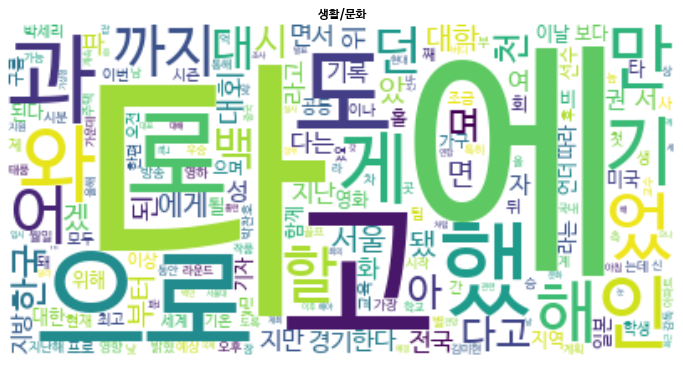

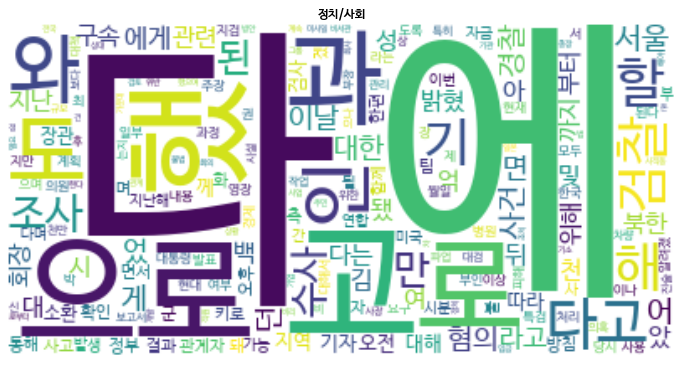

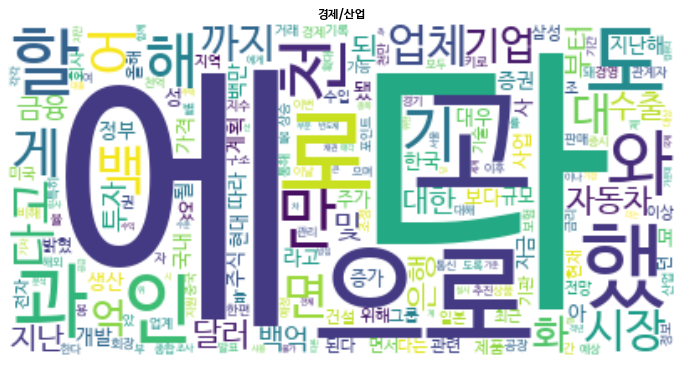

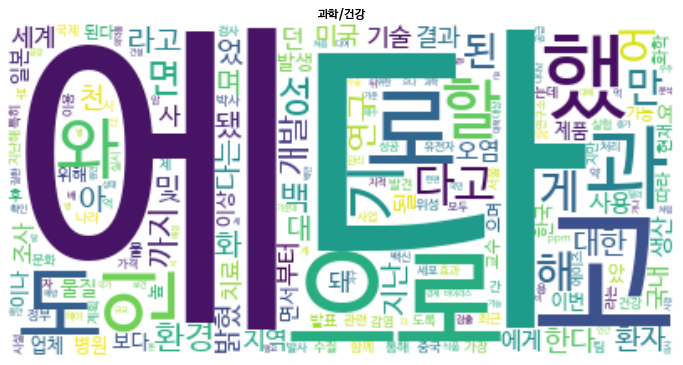

In [ ]:
for category in data['category'].unique().tolist():
    tokens_by_category = [word for tokens in data[data['category'] == category]['tokens'] for word in tokens]
    wordcloud(tokens_by_category, category)
    print('='*100)

üî•üî•üî• 

ÌïúÍ∏ÄÏùò ÍµêÏ∞©Ïñ¥ ÌäπÏÑ± ÎïåÎ¨∏Ïóê Ïóê, ÎèÑ, Ïù∏ Îì±Í≥º Í∞ôÏùÄ Ïñ¥ÎØ∏Í∞Ä Í∞ÄÏû• ÎßéÏùÄ ÎπàÎèÑÏàòÎ•º Î≥¥ÏûÑ..

Î™ÖÏÇ¨Îßå ÎúØÏñ¥ÏÑú Î¥êÎ≥ºÍπå?

In [ ]:
def get_nouns_only(text, tokenizer):
    nouns = tokenizer.nouns(text)
    nouns = [n for n in nouns if n not in stop_words]
    return nouns

In [ ]:
%%time

data['nouns'] = data['doc_clean'].apply(lambda x: get_nouns_only(x, mecab))

CPU times: user 39.7 s, sys: 346 ms, total: 40 s
Wall time: 39.9 s


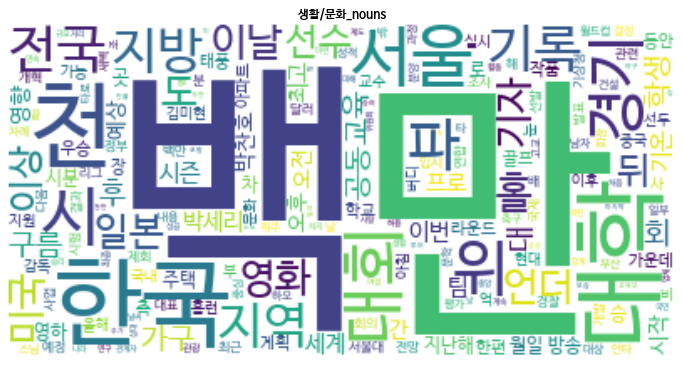

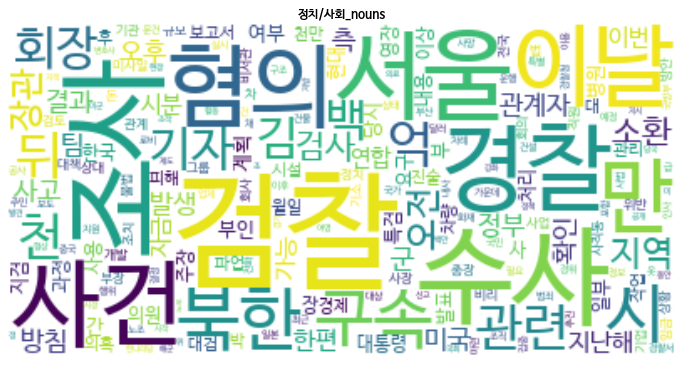

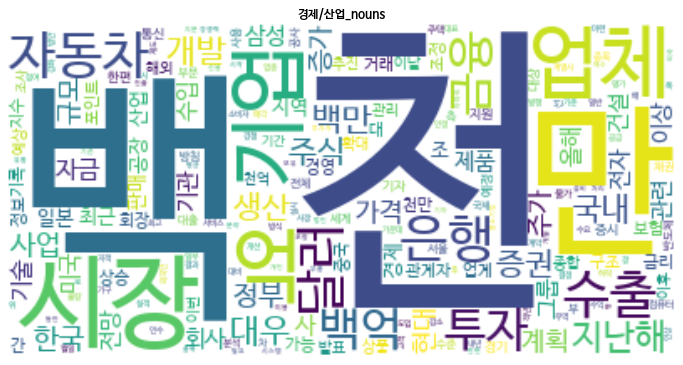

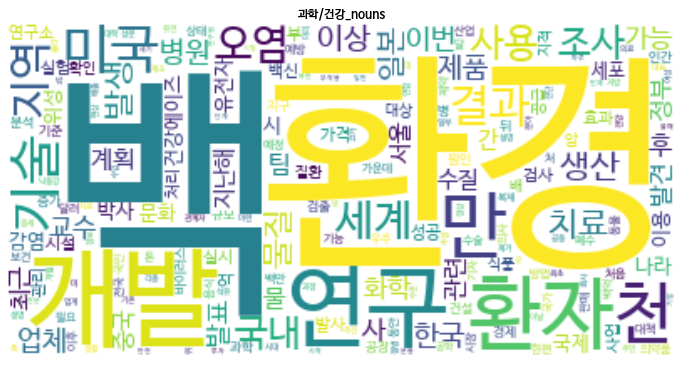

In [ ]:
for category in data['category'].unique():
    nouns_by_category = [n for nouns in data[data['category']==category]['nouns'] for n in nouns]
    wordcloud(nouns_by_category, category+'_nouns')
    print('='*100)

üî•üî•üî• 

Í∏∞ÏÇ¨ ÏõêÎ¨∏ÏóêÏÑú Î™ÖÏÇ¨Îßå Ï∂îÏ∂ú Ìïú Îí§ ÏãúÍ∞ÅÌôîÌïòÎãà ÌôïÏã§Ìûà Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ Îã®Ïñ¥Í∞Ä Î™ÖÌôïÌûà Îã§Î•∏ Í≤ÉÏùÑ Ïïå Ïàò ÏûàÏùå

In [ ]:
# data_clean.csv Ï†ÄÏû•
data.to_csv('data_clean.csv', index_label=False)

# Text Classification

In [ ]:
# data_clean.csv load
# csvÎ•º Î∂àÎü¨Ïò¨ Îïå Î¶¨Ïä§Ìä∏ ÌÉÄÏûÖ ÏπºÎüºÏùÑ Í∑∏ÎåÄÎ°ú Î∂àÎü¨Ïò§Í∏∞ ÏúÑÌï¥ converters ÌååÎùºÎØ∏ÌÑ∞ ÏÇ¨Ïö©

data_clean = pd.read_csv('data_clean.csv', converters={'tokens':eval, 'nouns':eval})
print(data_clean.shape)
data_clean.head()

(18784, 6)


document  ...                                              nouns
0   Ïó¨ÏÑ± ÌäπÏú†Ïùò Í∞êÏÑ±ÏÑ∏Í≥ÑÎ•º Í∑∏Î¶¨Í±∞ÎÇò ÏÑ±Ï∞®Î≥ÑÏùÑ Í≥†Î∞úÌïòÎäî ÎÇ¥Ïö©ÏùÑ Îã¥ÏùÄ Ïó¨ÏÑ±\n   Ï∑®Ìñ• ...  ...  [Ïó¨ÏÑ±, ÌäπÏú†, Í∞êÏÑ±, ÏÑ∏Í≥Ñ, ÏÑ±, Ï∞®Î≥Ñ, Í≥†Î∞ú, ÎÇ¥Ïö©, Ïó¨ÏÑ±, Ï∑®Ìñ•, ÏòÅÌôî, Ï°∞Ïù¥...
1  ÌäπÎ≥ÑÍ≤ÄÏÇ¨Ïóê Í∞ïÏõêÏùº-ÏµúÎ≥ëÎ™®\n<!-search 199910070941:hk:10:::...  ...  [ÌäπÎ≥Ñ, Í≤ÄÏÇ¨, Í∞ïÏõêÏùº, ÏµúÎ≥ëÎ™®, ÍπÄ, ÎåÄÌÜµÎ†π, ÏûÑÎ™Ö, ÏùºÌõÑ, Î≥∏Í≤©, ÏàòÏÇ¨, Ï∞©Ïàò,...
2   ÏÉàÌï¥Îì§Ïñ¥ Ï£ºÏãùÏãúÏû•Ïùò Í∏∞Í¥ÄÏû•ÏÑ∏ÌôîÍ∞Ä ÎçîÏö± Ïã¨ÌôîÎêòÍ≥† ÏûàÎäî Í≤ÉÏúºÎ°ú ÎÇòÌÉÄÎÇ¨Îã§.\n     ...  ...  [ÏÉàÌï¥, Ï£ºÏãù, ÏãúÏû•, Í∏∞Í¥ÄÏû•, ÏÑ∏Ìôî, Ïã¨Ìôî, Ï¶ùÍ∂åÏóÖ, Í∏àÏúµ, Ïã§Î™Ö, Ïã§Ïãú, Ïù¥ÌõÑ,...
3   Ï†ïÎ∂ÄÎäî 8Ïùº Ïò§Ï†Ñ Ïù¥ÌöåÏ∞ΩÏ¥ùÎ¶¨ Ï£ºÏû¨Î°ú Íµ≠Î¨¥ÌöåÏùòÎ•º Ïó¥Í≥† Ïö∞Î£®Í≥ºÏù¥ÎùºÏö¥Îìú(UR)\n   ...  ...  [Ï†ïÎ∂Ä, Ïò§Ï†Ñ, Ïù¥ÌöåÏ∞Ω, Ï¥ùÎ¶¨, Ï£ºÏû¨, Íµ≠Î¨¥, ÌöåÏùò, Ïö∞Î£®Í≥ºÏù¥, ÎùºÏö¥Îìú, ÌòëÏÉÅ, ÌõÑ...
4   ÏÑúÏö∏Í≥º Î∂ÄÏÇ∞ÏßÄÌïòÏ≤†ÎÖ∏Ï°∞Í∞Ä 23Ïùº Ïò§Ï†ÑÎ∂ÄÌÑ∞ Ï§ÄÎ≤ïÏö¥Ìñâ(Í∑úÏ†ïÏ§ÄÏàòÏö¥Ìñâ)Ïóê\n   Îì§Ïñ¥Í∞Ñ Í∞Ä...  ...  [ÏÑúÏö∏, Î∂ÄÏÇ∞, ÏßÄÌïòÏ≤†, ÎÖ∏Ï°∞, Ïò§Ï†Ñ, Ï§ÄÎ≤ï, Ïö¥Ìñâ, Í∑úÏ†ï, Ï§ÄÏàò, Ïö¥Ìñâ, Í∞ÄÏö¥Îç∞,...

[5 rows x 6 columns]

In [ ]:
docs = data_clean['doc_clean'].tolist()
tokens = data_clean['tokens'].tolist()
classes = data_clean['class'].tolist()

len(docs), len(tokens), len(classes)

(18784, 18784, 18784)

## Baseline (Naive-bayse classifier)

### TF-IDF Vectorization

In [ ]:
X_train_tokens, X_test_tokens, y_train, y_test = train_test_split\
                                                                    (
                                                                     tokens, 
                                                                     classes,
                                                                     stratify=classes,
                                                                     test_size=0.2,
                                                                     random_state=34
                                                                    )

len(X_train_tokens), len(X_test_tokens), len(y_train), len(y_test)

(15027, 3757, 15027, 3757)

In [ ]:
# ÌÜ†ÌÅ∞Ìôî Îêú Î¶¨Ïä§Ìä∏Î•º Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï¥ ÌòïÏãùÏ†ê Ìï®ÏàòÎ•º ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä ÌååÎùºÎØ∏ÌÑ∞Ïóê ÎÑ£Ïñ¥Ï§å

def identify_tokenizer(text):
    return text

In [ ]:
tfidf = TfidfVectorizer(tokenizer=identify_tokenizer,
                        lowercase=False)

tfidf_X_train = tfidf.fit_transform(X_train_tokens)
tfidf_X_test = tfidf.transform(X_test_tokens)

In [ ]:
tfidf_X_train.shape, tfidf_X_test.shape

((15027, 75183), (3757, 75183))

### Naive-bayes classifier

In [ ]:
nb_clf = MultinomialNB(alpha=0.01, fit_prior=True, class_prior=None)
# alpha: Ïä§Î¨¥Îî© ÌååÎùºÎØ∏ÌÑ∞(0Ïù¥Î©¥ Ïä§Î¨¥Îî©ÌïòÏßÄ ÏïäÏùå)
# fit_priorr: ÌÅ¥ÎûòÏä§Ïùò ÏÇ¨Ï†ÑÌôïÎ•†ÏùÑ ÏÇ¨Ïö©Ìï† Í≤ÉÏù∏ÏßÄ(bool)
# class_prior: ÌÅ¥ÎûòÏä§Ïùò ÏÇ¨Ï†ÑÌôïÎ•†, ÏßÄÏ†ïÌï¥Ï£ºÎ©¥ Îç∞Ïù¥ÌÑ∞Ïóê Îî∞Îùº Ï°∞Ï†ïÎêòÏßÄ ÏïäÏùå(array-like)
nb_clf.fit(tfidf_X_train, y_train)

y_pred = nb_clf.predict(tfidf_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       758
           1       0.89      0.84      0.87       986
           2       0.90      0.94      0.92      1837
           3       0.65      0.72      0.68       176

    accuracy                           0.88      3757
   macro avg       0.83      0.83      0.83      3757
weighted avg       0.88      0.88      0.88      3757



üî•üî•üî•

Í∏∞Î≥∏ Î≤†Ïù¥Ïä§ÎùºÏù∏ Î™®Îç∏Î°ú naive-bayes Î∂ÑÎ•òÍ∏∞ Î™®Îç∏ ÏÇ¨Ïö©

Îã®ÏàúÌïòÍ≤å Îã®Ïñ¥Ïùò ÎπàÎèÑÏàòÎßå Í≥†Î†§ÌïòÍ≥† Î¨∏Ïû•Ïùò ÏàúÏÑúÎ•º Í≥†Î†§ÌïòÏßÄ ÏïäÎäîÎã§Îäî ÌïúÍ≥ÑÏ†êÏù¥ ÏûàÏßÄÎßå ÏÉùÍ∞ÅÏô∏Î°ú ÏÉÅÎãπÌûà ÎÜíÏùÄ ÏÑ±Îä•ÏùÑ Î≥¥ÏûÑ

## DL model

### Bidirectional LSTM

In [ ]:
len(docs), len(classes)

(18784, 18784)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(docs, classes,
                                                    test_size=0.2,
                                                    stratify=classes,
                                                    random_state=34)

len(X_train), len(X_test), len(y_train), len(y_test)

(15027, 3757, 15027, 3757)

In [ ]:
print('ÎùºÎ≤®:', classes[0])
X_train[0]

ÎùºÎ≤®: 0


' Îã¥Î≥¥ÎÇò Î≥¥Ï¶ùÏù∏ ÏóÜÏù¥ Ïã†Ïö©ÎßåÏúºÎ°ú Ï¶âÏãú ÎåÄÏ∂úÏùÑ Î∞õÏùÑ Ïàò ÏûàÎäî Ïã†ÏÉÅÌíàÏù¥ ÎÇòÏôîÎã§ ÌïúÏùºÏùÄÌñâÏùÄ ÏïΩÏ†ïÏÑúÏóê ÌïúÎ≤à ÏÑúÎ™ÖÏúºÎ°ú Ï¶âÏãú ÎåÄÏ∂úÌï®ÏúºÎ°úÏç® ÎåÄÏ∂úÏ†àÏ∞®Î•º Í∞ÑÏÜåÌôîÌïòÍ≥† Îã¥Î≥¥Î•º Ï†úÍ≥µÌïòÍ±∞ÎÇò Î≥¥Ï¶ùÏù∏ÏùÑ ÏÑ∏Ïö∞ÏßÄ ÏïäÍ≥† Ïã†Ïö©ÎßåÏúºÎ°ú ÎåÄÏ∂úÏùÑ Ï∑®Í∏âÌïòÎäî Ïã†ÏÉÅÌíàÏù∏ ÌïúÎ≤àÏã∏Ïù∏ Ïã†Ïö©ÎåÄÏ∂úÏùÑ Í∞úÎ∞ú ÏùºÎ∂ÄÌÑ∞ Î∞úÎß§ÌïúÎã§ Ïù¥ ÏÉÅÌíàÏùÄ ÌäπÌûà ÏòàÍ∏àÏûîÏï°Ïù¥ÎÇò Í±∞ÎûòÍ∏∞Í∞Ñ Îì± Í≥ºÍ±∞Ïùò Í±∞ÎûòÏã§Ï†ÅÏóê Îî∞Îùº Ïã†Ïö© ÎåÄÏ∂ú Ïó¨Î∂Ä Î∞è ÎåÄÏ∂úÏï°Ïù¥ Í≤∞Ï†ïÎêòÎäî Í∏∞Ï°¥Ïùò Ïã†Ïö©ÎåÄÏ∂úÍ≥ºÎäî Îã¨Î¶¨ Ïã†Í∑ú Í±∞ÎûòÏûêÏóê ÎåÄÌï¥ÏÑúÎèÑ Ïã†Ïö©ÎßåÏúºÎ°ú ÎåÄÏ∂úÏùÑ Ìï¥Ï§ÄÎã§Îäî ÌäπÏßïÏùÑ Í∞ñÍ≥† ÏûàÎã§ ÎåÄÏ∂úÍ∏àÏï°ÏùÄ Ïã†Ïö©ÎèÑÏóê Îî∞Îùº ÏµúÍ≥† Ï≤úÎßåÏõêÍπåÏßÄ Í∞ÄÎä•ÌïòÎ©∞ Í∏àÎ¶¨Îäî Ïö∞ÎåÄÍ∏àÎ¶¨ ÌòÑÌñâ ÏóêÎã§ Ïùò Í∞ÄÏÇ∞Í∏àÎ¶¨Î•º Ìï©ÏÇ∞Ìïú Ïó∞ Î°ú Ïö∞ÎåÄÍ∏àÎ¶¨Ïùò Ïò§Î•¥ÎÇ¥Î¶ºÏóê Îî∞Îùº Í∏àÎ¶¨Î∂ÄÎã¥ÏùÄ Îã¨ÎùºÏßà ÏàòÎèÑ ÏûàÎã§ ÎåÄÏ∂úÍ∏∞Í∞ÑÏùÄ ÎÖÑÏúºÎ°ú ÌïòÎêò ÎßåÍ∏∞ Îïå ÌïÑÏöîÏóê Îî∞Îùº ÎåÄÏ∂úÍ∏∞Í∞ÑÏùÑ Ïó∞Ïû•Ìï† Ïàò ÏûàÏúºÎ©∞ Ïù¥Îïå ÎåÄÏ∂úÍ∏∞Í∞Ñ Ïó∞

In [ ]:
print('ÎùºÎ≤®:', classes[-1])
X_train[-1]

ÎùºÎ≤®: 2


' Í≥†Í∞ùÏù¥ Î≥¥ÌóòÌöåÏÇ¨Î°úÎ∂ÄÌÑ∞ ÎåÄÏ∂úÎ∞õÏùÄÌõÑ Í±∞ÎûòÏïΩÏ†ïÏùò ÏùºÎ∂ÄÎ•º ÏúÑÎ∞òÌñàÏùÑÎïå Ï†ïÎãπÌïú ÏµúÍ≥†Ï†àÏ∞®ÏóÜÏù¥ Ïó∞Ï≤¥Ïù¥ÏûêÎ•º Î∂ÄÍ≥ºÌïòÎèÑÎ°ù Ìïú Î≥¥ÌóòÌöåÏÇ¨Ïùò ÏïΩÍ¥ÄÏù¥ Î¨¥Ìö®ÌôîÎêêÎã§ Ïùº Í≥µÏ†ïÍ±∞ÎûòÏúÑÏõêÌöåÎäî ÎåÄÏ∂úÍ¥ÄÎ†® Î≥¥ÌóòÏóê Í∞ÄÏûÖÌïòÍ≥† ÎåÄÏ∂úÏùÑ Î∞õÏùÄ Í≥†Í∞ùÏù¥ ÎåÄÏ∂úÍ¥ÄÎ†® Î≥¥ÌóòÍ≥ÑÏïΩÏù¥ Î¨¥Ìö®ÎêòÍ±∞ÎÇò ÏÜåÎ©∏ÎêêÏùÑÎïå ÎåÄÏ∂úÏïΩÏ†ïÏù¥ ÏÜåÎ©∏Îêú Í≤ÉÏúºÎ°ú Î≥¥Í≥† Ï†ïÎãπÌïú ÌÜµÍ≥†Ï†àÏ∞®ÏóÜÏù¥ Ïó∞Ï≤¥Ïù¥ÏûêÎ•º Ï†ÅÏö©ÌïòÎèÑÎ°ù Ìïú Í∞ú ÏÉùÎ™ÖÎ≥¥ÌóòÏÇ¨ÏôÄ ÏÜêÌï¥Î≥¥ÌóòÏÇ¨Ïùò ÏïΩÍ¥ÄÏùÄ ÏïΩÍ¥ÄÎ≤ïÏóê ÏúÑÎ∞∞Îêú Í≤ÉÏù¥ÎùºÎ©¥ÏÑú Í¥ÄÎ†®Ï°∞Ìï≠ÏùÑ ÏÇ≠Ï†úÌïòÍ±∞ÎÇò ÏàòÏ†ïÌÜ†Î°ù ÌñàÎã§ Í≥µÏ†ïÏúÑÎäî ÎåÄÏ∂úÍ≥º Í¥ÄÎ†®Ìïú ÌäπÏ†ïÎ≥¥ÌóòÍ≥ÑÏïΩÏù¥ Î¨¥Ìö®Í∞Ä ÎêòÏóàÎçîÎùºÎèÑ Îã§Î•∏ Î≥¥Ìóò Í≥ÑÏïΩÏù¥ Ï°¥ÏÜçÎêòÍ≥† ÏûàÎäî Í≤ΩÏö∞ ÎåÄÏ∂úÏùÄ Ïú†Ìö®ÌïòÎ©∞ Î≥¥ÌóòÍ≥ÑÏïΩÏù¥ ÏôÑÏ†ÑÌûà ÏÉÅÏã§Îêú Í≤ΩÏö∞ÎùºÎèÑ ÏÉÅÎãπÌïú Í∏∞ÏùºÏóê Í±∏Ï≥ê ÏµúÍ≥†ÌïòÏßÄ ÏïäÍ≥† Ïó∞Ï≤¥Ïù¥ÏûêÎ•º Î∂ÄÍ≥ºÌïòÎäî Í≤ÉÏùÄ ÏûòÎ™ªÏù¥ÎùºÍ≥† Í∑∏ Ïù¥Ïú†Î•º Î∞ùÌòîÎã§ ÎòêÌïú Í≥†Í∞ùÏù¥ÎÇò Î≥¥Ï¶ùÏù∏Ïù¥ Î≥¥ÌóòÌöåÏÇ¨Ïùò Î™®Îì† Í±∞Îûò ÏïΩÏ†ïÏ

In [ ]:
all_tokens = [word for tokens in data_clean['tokens'] for word in tokens]
vocab = list(set(all_tokens))
vocab_size = len(vocab)

print('Ï†ÑÏ≤¥ ÌÜ†ÌÅ∞ Ïàò:', len(all_tokens))
print('Ï§ëÎ≥µ Ï†úÏô∏ ÌÜ†ÌÅ∞ Ïàò:', vocab_size)

Ï†ÑÏ≤¥ ÌÜ†ÌÅ∞ Ïàò: 4509845
Ï§ëÎ≥µ Ï†úÏô∏ ÌÜ†ÌÅ∞ Ïàò: 82077


In [ ]:
# tf keras tokenizer
tokenizer = Tokenizer(num_words=vocab_size) # ÏµúÎåÄ Îã®Ïñ¥ Ïàò=vocab_size

# ÏûÖÎ†•Îêú ÏΩîÌçºÏä§(X_train)Ïùò ÎπàÎèÑÏàòÎ•º Í∏∞Ï§ÄÏúºÎ°ú Îã®Ïñ¥ ÏßëÌï© ÏÉùÏÑ±
# ÌõàÎ†®ÏÖã ÌÖçÏä§Ìä∏ÏóêÎßå fit Ìï¥Ï£ºÎ©¥ Îê®, ÌÖåÏä§Ìä∏ÍπåÏßÄÌïòÎ©¥ ÎëêÎ≤à ÌïòÎäî Íº¥ÏûÑ
tokenizer.fit_on_texts(X_train) 

# encoded Îç∞Ïù¥ÌÑ∞ ÎßåÎì§Í∏∞
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Ï†ÑÏ≤¥ Î¨∏ÏÑúÏßëÌï©ÏóêÏÑú Í∞Å Îã®Ïñ¥Ïóê Î∂ÄÏó¨Îêú index ÌôïÏù∏ Í∞ÄÎä•Ìïú word_index ÌÅ¥ÎûòÏä§
word_index = tokenizer.word_index
print('Ï†ÑÏ≤¥ Î¨∏ÏÑúÏùò Îã®Ïñ¥ Ï¢ÖÎ•ò:', len(word_index))

maxlen = max([len(doc.split()) for doc in X_train]) # ÏãúÌÄÄÏä§Ïùò ÏµúÎåÄ Í∏∏Ïù¥ ÏÑ§Ï†ï, Ïó¨Í∏∞ÏÑúÎäî Í∞ÄÏû• Í∏¥ Î¨∏ÏÑúÎ•º Í∏∞Ï§ÄÏúºÎ°ú Ïû°Ïùå, ÏûòÎ¶¨Îäî ÏãúÌÄÄÏä§Í∞Ä ÏóÜÎèÑÎ°ù ÌïòÍ≤†Îã§Îäî Í≤É
embedding_dim = 128
max_features = len(word_index) + 1 # Ï†ÑÏ≤¥ Î¨∏ÏÑúÏùò Ï†ÑÏ≤¥ Îã®Ïñ¥Î•º Îã§ ÏÇ¨Ïö©ÌïòÍ≤†Îã§Îäî Í≤É

Ï†ÑÏ≤¥ Î¨∏ÏÑúÏùò Îã®Ïñ¥ Ï¢ÖÎ•ò: 510877


In [ ]:
maxlen, max_features

(1917, 510878)

In [ ]:
# Î¶¨Ïä§Ìä∏ ÌÉÄÏûÖÏùò Îç∞Ïù¥ÌÑ∞Î•º (samples, maxlen) ÌÅ¨Í∏∞Ïùò 2D Ï†ïÏàò ÌÖêÏÑúÎ°ú Î≥ÄÌôò
X_train_padding = pad_sequences(X_train_encoded, maxlen=maxlen)
X_test_padding = pad_sequences(X_test_encoded, maxlen=maxlen)

# Î¶¨Ïä§Ìä∏ ÌÉÄÏûÖÏùò Îç∞Ïù¥ÌÑ∞Î•º array ÌòïÌÉúÎ°ú Î≥ÄÌôò
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train_padding.shape, X_test_padding.shape, y_train.shape, y_test.shape

((15027, 1917), (3757, 1917), (15027,), (3757,))

In [ ]:
def create_BiLSTM(max_features=max_features, embedding_dim=embedding_dim, maxlen=maxlen):
    
    model = Sequential(name='BiLSTM')
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(SpatialDropout1D(0.5))

    # wrapper layer: unidirectional model => bidirectional model
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4))))
    model.add(Bidirectional(LSTM(128)))
    
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    return model

model_BiLSTM = create_BiLSTM()
model_BiLSTM.summary()

Model: "BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1917, 128)         65392384  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1917, 128)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1917, 256)         263168    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0    

In [ ]:
# checkpoint_filepath = 'BiLSTM-weights-best.hdf5'
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
#                                                          monitor='val_loss',
#                                                          verbose=1,
#                                                          mode='auto',
#                                                          save_freq='epoch',
#                                                          save_best_only=True,
#                                                          save_weights_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               mode='min',
                                               min_delta=1e-4,
                                               verbose=1,
                                               patience=3)

In [ ]:
model_BiLSTM.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

EPOCHS = 100
batch_size = 256

history = model_BiLSTM.fit(X_train_padding, y_train,
                        batch_size=batch_size,
                        epochs=EPOCHS,
                        validation_data = (X_test_padding, y_test),
                        callbacks=[checkpoint_callback, es_callback],
                        verbose=1)

Epoch 1/100
59/59 [==============================] - 79s 1s/step - loss: 0.8229 - accuracy: 0.6802 - val_loss: 0.6635 - val_accuracy: 0.7807

Epoch 00001: val_loss improved from inf to 0.66345, saving model to BiLSTM-weights-best.hdf5
Epoch 2/100
59/59 [==============================] - 70s 1s/step - loss: 0.4735 - accuracy: 0.8442 - val_loss: 0.5769 - val_accuracy: 0.8169

Epoch 00002: val_loss improved from 0.66345 to 0.57693, saving model to BiLSTM-weights-best.hdf5
Epoch 3/100
59/59 [==============================] - 70s 1s/step - loss: 0.3120 - accuracy: 0.9066 - val_loss: 0.6175 - val_accuracy: 0.8227

Epoch 00003: val_loss did not improve from 0.57693
Epoch 4/100
59/59 [==============================] - 70s 1s/step - loss: 0.2218 - accuracy: 0.9383 - val_loss: 0.6564 - val_accuracy: 0.8116

Epoch 00004: val_loss did not improve from 0.57693
Epoch 5/100
59/59 [==============================] - 70s 1s/step - loss: 0.1849 - accuracy: 0.9477 - val_loss: 0.7410 - val_accuracy: 0.8174

In [ ]:
loss, acc = model_BiLSTM.evaluate(X_test_padding, y_test, batch_size=batch_size)

15/15 [==============================] - 5s 327ms/step - loss: 0.7410 - accuracy: 0.8174


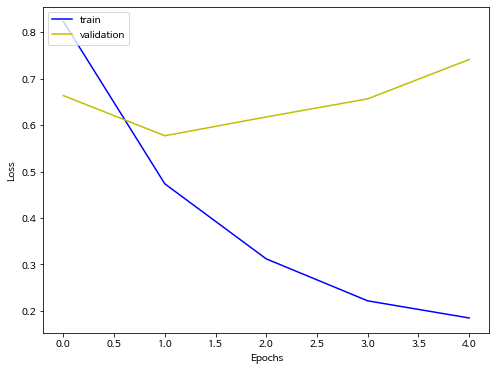

In [ ]:
fig, axes = plt.subplots(figsize=(8, 6))
axes.plot(history.history['loss'], 'b', label='train')
axes.plot(history.history['val_loss'], 'y', label='validation')
axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')
axes.legend(loc='upper left')
plt.show();

In [ ]:
y_pred = model_BiLSTM.predict(X_test_padding)
predicted_class = np.argmax(y_pred, axis=1)
print(classification_report(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       758
           1       0.88      0.77      0.82       986
           2       0.88      0.90      0.89      1837
           3       0.23      0.39      0.29       176

    accuracy                           0.82      3757
   macro avg       0.70      0.71      0.70      3757
weighted avg       0.84      0.82      0.83      3757



üî•üî•üî• 

baseline(naive-bayse Î∂ÑÎ•òÍ∏∞) Î≥¥Îã§ Ïò§ÌûàÎ†§ ÏÑ±Îä•Ïù¥ Ï¢ãÏßÄ ÏïäÏùå

Í±±Ï†ïÌñàÎçò Í≤ÉÏ≤òÎüº Îç∞Ïù¥ÌÑ∞Í∞Ä Ï†ÅÏùÄ Ïπ¥ÌÖåÍ≥†Î¶¨Îäî Í±∞Ïùò ÎßûÌûàÏßÄ Î™ªÌï®

Îç∞Ïù¥ÌÑ∞ Î∂àÍ∑†Ìòï Î¨∏Ï†úÎ•º Ìï¥Í≤∞Ìï† ÌïÑÏöîÍ∞Ä ÏûàÎäî Í≤É Í∞ôÏùå

# Data Agumentation
- back-translate: ÌïúÍµ≠Ïñ¥ -> ÏòÅÏñ¥ -> ÌïúÍµ≠Ïñ¥
- Î∂àÍ∑†ÌòïÌïú Í≥ºÌïô/Í±¥Í∞ï Ïπ¥ÌÖåÍ≥†Î¶¨ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤¥Î•º (ÏòÅÏñ¥, ÏùºÎ≥∏Ïñ¥, Ï§ëÍµ≠Ïñ¥)Î°ú back-translate ÌïòÍ≥†Ïûê ÌñàÏßÄÎßå, Î≤àÏó≠apiÎäî 1Ïùº Îã®Ïñ¥ ÏàòÍ∞Ä Ï†úÌïúÎêòÏñ¥ ÏûàÍ≥† seleniumÏùÑ ÌôúÏö©ÌïòÎãà ÏãúÍ∞ÑÏù¥ ÎÑàÎ¨¥ Ïò§ÎûòÍ±∏Î†§ÏÑú ÎèÑÏ§ëÏóê Ï§ëÎã®Ìï® => 239Í∞ú ÏÉùÏÑ±

In [ ]:
backtrans_docs = pd.read_csv('backtrans_·ÑÄ·Ö™·Ñí·Ö°·Ü®·ÑÄ·Ö•·Ü´·ÑÄ·Ö°·Üº_317·ÑÄ·Ö¢.csv').drop(columns='Unnamed: 0')
backtrans_docs['category'] = 'Í≥ºÌïô/Í±¥Í∞ï'
backtrans_docs['class'] = 3
backtrans_docs.rename(columns={'0' : 'doc_clean'}, inplace=True)
print(len(backtrans_docs))
backtrans_docs.head()

317


doc_clean category  class
0  Ìï©ÏÑ±ÏÑ∏Ï†ú ÏÉùÏÇ∞Í∏∞Ïà† Í∞úÎ∞úÍ≥º ÌôòÍ≤ΩÏò§Ïóº Î∞©ÏßÄÎ•º ÏúÑÌïú Ï†úÏ°∞ÏóÖÏ≤¥Ïùò ÎÖ∏Î†•Ïù¥ Ìï©ÏÑ±ÏÑ∏Ï†úÏùò Ïò§Ïóº Ïú†...    Í≥ºÌïô/Í±¥Í∞ï      3
1  ÏàòÎèÑÍ∂å 1Ï≤úÎßå Ï£ºÎØºÏùò ÏÉÅÏàòÏõêÏù∏ ÌåîÎãπÌò∏Î°ú Ïú†ÏûÖÎêòÎäî Í≤ΩÍ∏∞ÎèÑ Ï£ºÏöî ÌïòÏ≤úÏùò Ïò§ÏóºÎèÑÍ∞Ä ÏßÄÎÇúÌï¥...    Í≥ºÌïô/Í±¥Í∞ï      3
2  Ïù¥Ï¢ÖÌôò ÏÇºÏòÅÌôî ÎåÄÌëúÍ∞Ä ÎåÄÍ∑úÎ™® ÏãúÏÑ§ Ï¶ùÏÑ§Ïóê ÎÇòÏÑ∞Îã§. ÌöåÏÇ¨ Ï∏°ÏùÄ BOPPÍ∞Ä ÏÑúÏö∏ Íµ¨Î°úÎèô...    Í≥ºÌïô/Í±¥Í∞ï      3
3  ÏµúÍ∑º Íµ¨Ï†úÏó≠Ïù¥ ÌôïÏÇ∞ÎêòÎ©¥ÏÑú ÎÖπÏã≠ÏûêÏÇ¨Îäî ÌäπÏàòÎ•º ÎàÑÎ¶¨Í≥† ÏûàÍ≥†, Ïú†ÏùºÌïòÍ≤å Íµ¨Ï†úÏó≠ Ïû¨Î∞úÏùÑ Ìï†...    Í≥ºÌïô/Í±¥Í∞ï      3
4  ÏûêÍ∏∞ ÎπÑÌåê ÏûêÍ∏∞ ÎπÑÌåêÏùÄ ÎØºÏ£ºÏ£ºÏùòÏùò ÎπÑÎ∞Ä Î¨¥Í∏∞Ïù¥Î©∞, Ï†ïÏπòÏ†Å Í±¥Í∞ïÏùÑ ÏúÑÌï¥ÏÑúÎäî ÏÜîÏßÅÌï®Í≥º ...    Í≥ºÌïô/Í±¥Í∞ï      3

In [ ]:
backtrans_docs['doc_clean'][0]

'Ìï©ÏÑ±ÏÑ∏Ï†ú ÏÉùÏÇ∞Í∏∞Ïà† Í∞úÎ∞úÍ≥º ÌôòÍ≤ΩÏò§Ïóº Î∞©ÏßÄÎ•º ÏúÑÌïú Ï†úÏ°∞ÏóÖÏ≤¥Ïùò ÎÖ∏Î†•Ïù¥ Ìï©ÏÑ±ÏÑ∏Ï†úÏùò Ïò§Ïóº Ïú†Î∞ú Ìö®Í≥ºÎ•º Í±∞Ïùò ÏóÜÏï¥ÏßÄÎßå ÏóÖÍ≥ÑÎäî Î≤ï Í∞úÏ†ïÏùÑ ÏöîÍµ¨ÌïòÍ≥† ÎÇòÏÑ∞Îã§. ÌïúÍµ≠ÎπÑÎàÑÏÑ∏Ï†úÏÇ∞ÏóÖÏó∞Ìï©ÌöåÎäî ÏµúÍ∑º ÌôòÍ≤ΩÎ∂ÄÏóê Ï†úÏ∂úÌïú ÏßÑÏ†ïÏÑúÏóêÏÑú Ìï¥ÏàòÎ∂ÄÍ∞Ä ÏàòÏßàÏò§ÏóºÏùÑ ÎßâÍ∏∞ ÏúÑÌï¥ Íµ¨Î¶¨¬∑ÎÇ© Îì± Ï§ëÍ∏àÏÜç ÌéòÎÜÄÍ≥º ÎèÖÏÑ±Î¨ºÏßàÍ≥º Ìï®Íªò Ìï©ÏÑ±ÏÑ∏Ï†úÎ•º Ìè¨Ìï®ÌïòÍ∏∞Î°ú Ìïú Í≤ÉÏùÄ Î¨º Í±¥ÎÑàÍ∞îÎã§Í≥† ÏßÄÏ†ÅÌñàÎã§. ÏùºÏÜùÏÑ∏Ï†úÌòëÌöåÏóê Îî∞Î•¥Î©¥ ÏßÄÎÇúÌï¥ Íµ≠ÎÇ¥ÏóêÏÑú ÏÉùÏÇ∞Îêú Ï≤´ Ìï©ÏÑ±ÏÑ∏Ï†úÍ∞Ä ÏÉùÎ∂ÑÌï¥ÎêòÍ∏∞ Ïñ¥Î†§Ïö¥ ABS Í≤ΩÏÑ±ÏÑ∏Ï†úÏùò Ï£ºÏõêÎ£åÏòÄÍ≥†, ÌòÑÏû¨ ÎØ∏Íµ≠Í≥º ÏùºÎ≥∏Ïùò ÏµúÍ≥†ÏàòÏ§ÄÏùò Ï≤úÏó∞ÏÑ∏Ï†úÏôÄ ÌôòÍ≤ΩÎ≥¥Ï°¥Í∏∞Ïà†Ïù¥ ÏÉùÎ∂ÑÌï¥ÏÑ±Ïù¥ ÎÜíÏùÄ Í≤ÉÏúºÎ°ú ÎÇòÌÉÄÎÇ¨Îã§.ÎÖ∏Ï°∞Îäî Í∑∏Î†áÎã§Í≥† Ï£ºÏû•ÌïúÎã§. ÎπÑÎàÑÏÑ∏Ï†úÌòëÌöåÎäî Í≥ÑÏÜçÌï¥ÏÑú Î≤ïÏùÑ Í∞úÏ†ïÌïòÍ≥† ÏàòÏßàÏò§ÏóºÏùÑ ÏÑ§Î™ÖÌïòÎäî ÌïòÏ≤úÏùò ÎπÑÎàÑÍ±∞Ìíà ÏÇ¨ÏßÑÏùÑ Ï§ë¬∑Í≥†Íµê ÍµêÍ≥ºÏÑúÏùò ÌôòÍ≤Ω Í≥ºÎ™©Ïóê Ï†úÍ±∞ÌïòÎèÑÎ°ù ÏöîÍµ¨Ìï®ÏúºÎ°úÏç® Ìï©ÏÑ±ÏÑ∏Ï†úÏóê ÎåÄÌïú ÏûòÎ™ªÎê

In [ ]:
backtrans_docs.dropna(inplace=True)

In [ ]:
backtrans_docs['doc_clean'] = backtrans_docs['doc_clean'].apply(lambda x: text_preprocessing(x))
backtrans_docs['tokens'] = backtrans_docs['doc_clean'].apply(lambda x: text_to_morphs(x, mecab))
backtrans_docs.head()

doc_clean  ...                                             tokens
0  Ìï©ÏÑ±ÏÑ∏Ï†ú ÏÉùÏÇ∞Í∏∞Ïà† Í∞úÎ∞úÍ≥º ÌôòÍ≤ΩÏò§Ïóº Î∞©ÏßÄÎ•º ÏúÑÌïú Ï†úÏ°∞ÏóÖÏ≤¥Ïùò ÎÖ∏Î†•Ïù¥ Ìï©ÏÑ±ÏÑ∏Ï†úÏùò Ïò§Ïóº Ïú†...  ...  [Ìï©ÏÑ±, ÏÑ∏Ï†ú, ÏÉùÏÇ∞, Í∏∞Ïà†, Í∞úÎ∞ú, Í≥º, ÌôòÍ≤Ω, Ïò§Ïóº, Î∞©ÏßÄ, ÏúÑÌïú, Ï†úÏ°∞, ÏóÖÏ≤¥...
1  ÏàòÎèÑÍ∂å Ï≤úÎßå Ï£ºÎØºÏùò ÏÉÅÏàòÏõêÏù∏ ÌåîÎãπÌò∏Î°ú Ïú†ÏûÖÎêòÎäî Í≤ΩÍ∏∞ÎèÑ Ï£ºÏöî ÌïòÏ≤úÏùò Ïò§ÏóºÎèÑÍ∞Ä ÏßÄÎÇúÌï¥Î≥¥...  ...  [ÏàòÎèÑ, Í∂å, Ï≤úÎßå, Ï£ºÎØº, ÏÉÅÏàò, ÏõêÏù∏, Ìåî, ÎãπÌò∏, Î°ú, Ïú†ÏûÖ, Í≤ΩÍ∏∞ÎèÑ, Ï£ºÏöî,...
2  Ïù¥Ï¢ÖÌôò ÏÇºÏòÅÌôî ÎåÄÌëúÍ∞Ä ÎåÄÍ∑úÎ™® ÏãúÏÑ§ Ï¶ùÏÑ§Ïóê ÎÇòÏÑ∞Îã§ ÌöåÏÇ¨ Ï∏°ÏùÄ BOPPÍ∞Ä ÏÑúÏö∏ Íµ¨Î°úÎèôÏóê...  ...  [Ïù¥Ï¢ÖÌôò, ÏÇº, ÏòÅÌôî, ÎåÄÌëú, ÎåÄ, Í∑úÎ™®, ÏãúÏÑ§, Ï¶ùÏÑ§, Ïóê, ÎÇòÏÑ∞, Îã§, ÌöåÏÇ¨, ...
3  ÏµúÍ∑º Íµ¨Ï†úÏó≠Ïù¥ ÌôïÏÇ∞ÎêòÎ©¥ÏÑú ÎÖπÏã≠ÏûêÏÇ¨Îäî ÌäπÏàòÎ•º ÎàÑÎ¶¨Í≥† ÏûàÍ≥† Ïú†ÏùºÌïòÍ≤å Íµ¨Ï†úÏó≠ Ïû¨Î∞úÏùÑ Ìï† ...  ...  [ÏµúÍ∑º, Íµ¨Ï†úÏó≠, ÌôïÏÇ∞, Î©¥ÏÑú, ÎÖπÏã≠Ïûê, ÏÇ¨, ÌäπÏàò, ÎàÑÎ¶¨, Í≥†, Í≥†, Ïú†Ïùº, Í≤å,...
4  ÏûêÍ∏∞ ÎπÑÌåê ÏûêÍ∏∞ ÎπÑÌåêÏùÄ ÎØºÏ£ºÏ£ºÏùòÏùò ÎπÑÎ∞Ä Î¨¥Í∏∞Ïù¥Î©∞ Ï†ïÏπòÏ†Å Í±¥Í∞ïÏùÑ ÏúÑÌï¥ÏÑúÎäî ÏÜîÏßÅÌï®Í≥º ÏÇ¨...  ...  [ÏûêÍ∏∞, ÎπÑÌåê, ÏûêÍ∏∞, ÎπÑÌåê, ÎØºÏ£ºÏ£ºÏùò, ÎπÑÎ∞Ä, Î¨¥Í∏∞, Î©∞, Ï†ïÏπò, Í±¥Í∞ï, ÏúÑÌï¥ÏÑú,...

[5 rows x 4 columns]

In [ ]:
print('Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞:')
len(docs), len(tokens), len(classes)

Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞:


(18784, 18784, 18784)

In [ ]:
# Î¶¨Ïä§Ìä∏Ïóê Ï¶ùÍ∞ïÎç∞Ïù¥ÌÑ∞Î•º Ïù¥Ïñ¥ Î∂ôÏó¨Ï§å
docs.extend(backtrans_docs['doc_clean'])
tokens.extend(backtrans_docs['tokens'])
classes.extend(backtrans_docs['class'])
print('Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞+Ï¶ùÍ∞ï:')
len(docs), len(tokens), len(classes)

Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞+Ï¶ùÍ∞ï:


(19023, 19023, 19023)

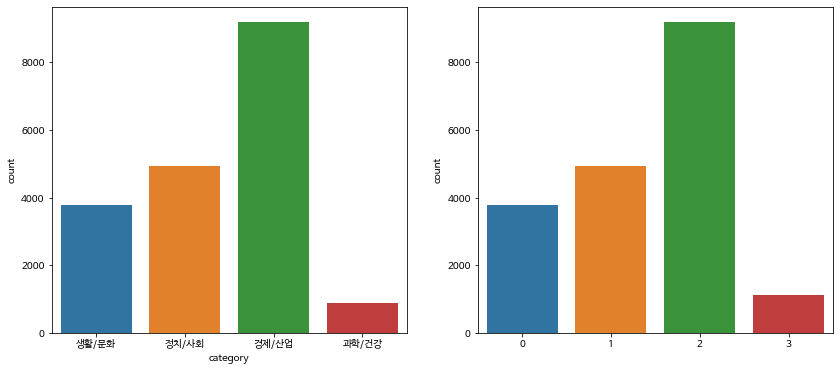

879ÏóêÏÑú 1118Î°ú 239ÎßåÌÅº Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.countplot(x=data['category'], ax=axes[0])
sns.countplot(x=classes, ax=axes[1])
plt.show();

original = data['category'].tolist().count('Í≥ºÌïô/Í±¥Í∞ï')
after_agumentation = classes.count(3)

print(f'{original}ÏóêÏÑú {after_agumentation}Î°ú {after_agumentation-original}ÎßåÌÅº Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï')

## Naive-bayese classifier(after agumentation)

In [ ]:
X_train_tokens, X_test_tokens, y_train, y_test = train_test_split\
                                                                    (
                                                                     tokens, 
                                                                     classes,
                                                                     stratify=classes,
                                                                     test_size=0.2,
                                                                     random_state=34
                                                                    )

len(X_train_tokens), len(X_test_tokens), len(y_train), len(y_test)

def identify_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identify_tokenizer,
                        lowercase=False)

tfidf_X_train = tfidf.fit_transform(X_train_tokens)
tfidf_X_test = tfidf.transform(X_test_tokens)

tfidf_X_train.shape, tfidf_X_test.shape

((15218, 75437), (3805, 75437))

In [ ]:
# tfidf vectorizer save
pickle.dump(tfidf, open('tfidf.pickle', 'wb'))

In [ ]:
tfidf_X_train.shape, tfidf_X_test.shape

((15218, 75437), (3805, 75437))

In [ ]:
nb_clf = MultinomialNB(alpha=0.01, fit_prior=True, class_prior=None)
nb_clf.fit(tfidf_X_train, y_train)

y_pred = nb_clf.predict(tfidf_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       758
           1       0.89      0.85      0.87       986
           2       0.89      0.94      0.91      1837
           3       0.72      0.74      0.73       224

    accuracy                           0.88      3805
   macro avg       0.85      0.84      0.84      3805
weighted avg       0.88      0.88      0.88      3805



### NB model 10-fold cv

In [ ]:
X = tfidf.fit_transform(tokens)
y = classes

In [ ]:
X.shape, len(y)

((19023, 82285), 19023)

In [ ]:
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
scoring = ['accuracy', 'f1_macro', 'f1_weighted']
cv_scores = {}

for s in scoring:
    cv_scores[s] = cross_val_score(nb_clf, X, y, scoring=s, cv=cv, n_jobs=-1)

In [ ]:
nb_10cv_df = pd.DataFrame.from_dict(cv_scores)
nb_10cv_df

accuracy  f1_macro  f1_weighted
0  0.887546  0.849650     0.886848
1  0.896479  0.854600     0.896247
2  0.885444  0.851429     0.885639
3  0.874869  0.823699     0.874539
4  0.882229  0.848578     0.881747
5  0.881178  0.838532     0.880429
6  0.877497  0.837863     0.876475
7  0.880126  0.831362     0.879331
8  0.874343  0.834363     0.874137
9  0.876972  0.845056     0.876604

In [ ]:
nb_10cv_df.describe()

accuracy   f1_macro  f1_weighted
count  10.000000  10.000000    10.000000
mean    0.881668   0.841513     0.881200
std     0.006753   0.009955     0.006832
min     0.874343   0.823699     0.874137
25%     0.877103   0.835238     0.876508
50%     0.880652   0.841794     0.879880
75%     0.884640   0.849382     0.884666
max     0.896479   0.854600     0.896247

In [ ]:
nb_10cv_df.to_csv('nb_10cv.csv', index_label=False)

### NB clf model save

In [ ]:
joblib.dump(nb_clf, 'nb_clf_model.pkl')

load_model = joblib.load('nb_clf_model.pkl')
y_pred = load_model.predict(tfidf_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       758
           1       0.89      0.85      0.87       986
           2       0.89      0.94      0.91      1837
           3       0.72      0.74      0.73       224

    accuracy                           0.88      3805
   macro avg       0.85      0.84      0.84      3805
weighted avg       0.88      0.88      0.88      3805



## Bidirectional LSTM(after agumentation)

In [ ]:
len(docs), len(classes), len(tokens)

(19023, 19023, 19023)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(docs, classes,
                                                    test_size=0.2,
                                                    stratify=classes,
                                                    random_state=34)

len(X_train), len(X_test), len(y_train), len(y_test)

(15218, 3805, 15218, 3805)

In [ ]:
all_tokens = [word for words in tokens for word in words]
vocab = list(set(all_tokens))
vocab_size = len(vocab)

print('Ï†ÑÏ≤¥ ÌÜ†ÌÅ∞ Ïàò:', len(all_tokens))
print('Ï§ëÎ≥µ Ï†úÏô∏ ÌÜ†ÌÅ∞ Ïàò:', vocab_size)

Ï†ÑÏ≤¥ ÌÜ†ÌÅ∞ Ïàò: 4536355
Ï§ëÎ≥µ Ï†úÏô∏ ÌÜ†ÌÅ∞ Ïàò: 82285


In [ ]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train) 

X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print('Ï†ÑÏ≤¥ Î¨∏ÏÑúÏùò Îã®Ïñ¥ Ï¢ÖÎ•ò:', len(word_index))

maxlen = max([len(doc.split()) for doc in X_train])
embedding_dim = 128
max_features = len(word_index) + 1

Ï†ÑÏ≤¥ Î¨∏ÏÑúÏùò Îã®Ïñ¥ Ï¢ÖÎ•ò: 512817


In [ ]:
# keras tokenizer save
pickle.dump(tokenizer, open('tokenizer.pickle', 'wb'))

In [ ]:
maxlen, max_features

(1917, 512818)

In [ ]:
X_train_padding = pad_sequences(X_train_encoded, maxlen=maxlen)
X_test_padding = pad_sequences(X_test_encoded, maxlen=maxlen)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
model = create_BiLSTM()
model.summary()

Model: "BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1917, 128)         65640704  
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 1917, 128)         0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 1917, 256)         263168    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0    

In [ ]:
# checkpoint_filepath = 'BiLSTM-weights-best-usingAugumentation.hdf5'
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
#                                                          monitor='val_loss',
#                                                          verbose=1,
#                                                          mode='auto',
#                                                          save_freq='epoch',
#                                                          save_best_only=True,
#                                                          save_weights_only=True)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               mode='min',
                                               min_delta=1e-4,
                                               verbose=1,
                                               patience=3)

In [ ]:
model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

EPOCHS = 100
batch_size = 256

history = model.fit(X_train_padding, y_train,
                        batch_size=batch_size,
                        epochs=EPOCHS,
                        validation_data=(X_test_padding, y_test),
                        callbacks=[checkpoint_callback, es_callback],
                        verbose=1)

Epoch 1/100
60/60 [==============================] - 81s 1s/step - loss: 1.0798 - accuracy: 0.5603 - val_loss: 0.7773 - val_accuracy: 0.7146

Epoch 00001: val_loss improved from inf to 0.77728, saving model to BiLSTM-weights-best-usingAugumentation.hdf5
Epoch 2/100
60/60 [==============================] - 72s 1s/step - loss: 0.5574 - accuracy: 0.8123 - val_loss: 0.6011 - val_accuracy: 0.8053

Epoch 00002: val_loss improved from 0.77728 to 0.60115, saving model to BiLSTM-weights-best-usingAugumentation.hdf5
Epoch 3/100
60/60 [==============================] - 72s 1s/step - loss: 0.3389 - accuracy: 0.8958 - val_loss: 0.6692 - val_accuracy: 0.7758

Epoch 00003: val_loss did not improve from 0.60115
Epoch 4/100
60/60 [==============================] - 72s 1s/step - loss: 0.2112 - accuracy: 0.9388 - val_loss: 0.6983 - val_accuracy: 0.8066

Epoch 00004: val_loss did not improve from 0.60115
Epoch 5/100
60/60 [==============================] - 72s 1s/step - loss: 0.1568 - accuracy: 0.9618 - v

In [ ]:
y_pred = model.predict(X_test_padding)
predicted_class = np.argmax(y_pred, axis=1)
print(classification_report(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.85      0.67      0.75       758
           1       0.82      0.80      0.81       986
           2       0.88      0.89      0.88      1837
           3       0.36      0.62      0.46       224

    accuracy                           0.81      3805
   macro avg       0.73      0.74      0.72      3805
weighted avg       0.83      0.81      0.81      3805



In [ ]:
print('weighted:', f1_score(y_test, predicted_class, average='weighted'))
print('macro:', f1_score(y_test, predicted_class, average='macro'))
print('micro:', f1_score(y_test, predicted_class, average='micro'))

weighted: 0.8126547400425719
macro: 0.7248440125920256
micro: 0.8065703022339029



- **average=micro says** 

    the function to compute f1 by considering total true positives, false
    negatives and false positives (no matter of the prediction for each 
    label in the dataset)

- **average=macro says** 
    
    the function to compute f1 for each label, and returns the average 
    without considering the proportion for each label in the dataset.

- **average=weighted says** 
    
    the function to compute f1 for each label, and returns the average 
    considering the proportion for each label in the dataset.

### Load model-weights(BiLSTM)

In [ ]:
max_features = 512818
embedding_dim = 128 
maxlen = 1917

def create_BiLSTM(max_features=max_features, embedding_dim=embedding_dim, maxlen=maxlen):
    
    model = Sequential(name='BiLSTM')
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(SpatialDropout1D(0.5))

    # wrapper layer: unidirectional model => bidirectional model
    model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4))))
    model.add(Bidirectional(LSTM(128)))
    
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
    
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    return model

model = create_BiLSTM()
model.summary()

Model: "BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1917, 128)         65640704  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1917, 128)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1917, 256)         263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0    

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.load_weights('BiLSTM-weights-best-usingAugumentation.hdf5')
loss, acc = model.evaluate(X_test_padding, y_test, batch_size=batch_size)

15/15 [==============================] - 10s 326ms/step - loss: 0.6011 - accuracy: 0.8053


### BiLSTM 10-fold cv

In [ ]:
X_train_padding.shape, X_test_padding.shape, y_train.shape, y_test.shape

((15218, 1917), (3805, 1917), (15218,), (3805,))

In [ ]:
X_padding = np.concatenate((X_train_padding, X_test_padding), axis=0)
y_padding = np.concatenate((y_train, y_test), axis=0)
X_padding.shape, y_padding.shape

((19023, 1917), (19023,))

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=34)
cv_acc = []
cv_weighted = []
cv_macro = []
cv_micro = []

for train_idx, test_idx in kfold.split(X_padding, y_padding):
    model = create_BiLSTM()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_padding[train_idx], y_padding[train_idx], epochs=5, batch_size=batch_size, verbose=1)

    loss, acc = model.evaluate(X_padding[test_idx], y_padding[test_idx], verbose=0)

    print(f'{model.metrics_names[1]}: {acc}')
    print(f'{model.metrics_names[0]}: {loss}')

    y_pred = model.predict(X_padding[test_idx])
    predicted_class = np.argmax(y_pred, axis=1)
    print(classification_report(y_padding[test_idx], predicted_class))
    
    cv_acc.append(acc)
    cv_weighted.append(f1_score(y_padding[test_idx], predicted_class, average='weighted'))
    cv_macro.append(f1_score(y_padding[test_idx], predicted_class, average='macro'))
    cv_micro.append(f1_score(y_padding[test_idx], predicted_class, average='micro'))
    
    print('='*100)

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       379
           1       0.86      0.79      0.82       493
           2       0.88      0.90      0.89       918
           3       0.40      0.59      0.48       112

    accuracy                           0.82      1902
   macro avg       0.74      0.75      0.74      1902
weighted avg       0.83      0.82      0.82      1902

Epoch 1/5
67/67 [==============================] - 74s 1s/step - loss: 1.0638 - accuracy: 0.5656
Epoch 2/5
67/67 [==============================] - 68s 1s/step - loss: 0.5607 - accuracy: 0.8133
Epoch 3/5
67/67 [==============================] - 68s 1s/step - loss: 0.3290 - accuracy: 0.8955
Epoch 4/5
67/67 [==============================] - 68s 1s/step - loss: 0.2244 - accuracy: 0.9352
Epoch 5/5
67/67 [==============================] - 68s 1s/step - loss: 0.1777 - accuracy: 0.9555
accuracy: 0.8222923278808594
loss: 0.737648606300354
              precision    

In [ ]:
lstm_10cv_df = pd.DataFrame(columns=['acc', 'weighted', 'macro', 'micro'])
lstm_10cv_df['acc'] = cv_acc
lstm_10cv_df['weighted'] = cv_weighted
lstm_10cv_df['macro'] = cv_macro
lstm_10cv_df['micro'] = cv_micro

lstm_10cv_df

acc  weighted     macro     micro
0  0.812401  0.814266  0.720324  0.812401
1  0.812401  0.812323  0.722154  0.812401
2  0.821335  0.824197  0.733018  0.821335
3  0.818086  0.824401  0.717960  0.818086
4  0.827024  0.831134  0.729389  0.827024
5  0.801788  0.813983  0.719259  0.801788
6  0.823870  0.825601  0.751917  0.823870
7  0.815457  0.826806  0.735894  0.815457
8  0.821241  0.824807  0.740868  0.821241
9  0.822292  0.823207  0.724994  0.822292

In [ ]:
lstm_10cv_df.describe()

acc   weighted      macro      micro
count  10.000000  10.000000  10.000000  10.000000
mean    0.817590   0.822072   0.729578   0.817590
std     0.007350   0.006299   0.010962   0.007350
min     0.801788   0.812323   0.717960   0.801788
25%     0.813165   0.816501   0.720781   0.813165
50%     0.819663   0.824299   0.727192   0.819664
75%     0.822053   0.825402   0.735175   0.822053
max     0.827024   0.831134   0.751917   0.827024

In [ ]:
lstm_10cv_df.to_csv('lstm_10cv.csv', index_label=False)

### Keras-tuner

In [ ]:
max_features, embedding_dim, maxlen

(512818, 128, 1917)

In [ ]:
def model_builder(hp):
    model = Sequential(name='BiLSTM-kerastuner')
    
    hp_bidirectional = hp.Int('bidirectional', min_value=128, max_value=256, step=32)
    hp_dense = hp.Int('dense', min_value=64, max_value=512, step=64)
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid', 'elu'], default='relu')
    hp_dropout1d = hp.Float('dropout1d', min_value=0.3, max_value=0.6, step=0.1)
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.6, step=0.1)
    hp_regularizer = hp.Choice('regularizer', values=[1e-3, 1e-4, 1e-5, 1e-6])
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])

    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(SpatialDropout1D(hp_dropout1d))

    model.add(Bidirectional(LSTM(hp_bidirectional, return_sequences=True, kernel_regularizer=regularizers.l2(hp_regularizer))))
    model.add(Bidirectional(LSTM(hp_bidirectional)))

    model.add(Dropout(hp_dropout))
    model.add(Dense(hp_dense, activation=hp_activation, kernel_regularizer=regularizers.l2(hp_regularizer)))

    model.add(Dropout(hp_dropout))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(
                     model_builder,
                     objective='val_loss',
                     seed=34,
                     max_epochs=10, # Î™®Îç∏ÏùÑ ÌïôÏäµÌï† ÏµúÎåÄ epoch
                     executions_per_trial=3, # Í∞Å trial ÎÇ¥Ïóê Íµ¨Ï∂ïÌï† Î™®Îç∏ Ïàò
                     directory='kerastuning',
                     project_name='BiLSTM_clf_tuning'
)

üî• HyperbandÎäî 1 + log"factor"^(max_epochs)^ Î•º Í≥ÑÏÇ∞ÌïòÍ≥† Ïù¥Î•º Í∞ÄÏû• Í∞ÄÍπåÏö¥ Ï†ïÏàòÎ°ú Î∞òÏò¨Î¶ºÌïòÏó¨ Ìïú Î∏åÎûòÌÇ∑ÏóêÏÑú ÌõàÎ†®Ìï† Î™®Îç∏ ÏàòÎ•º Í≤∞Ï†ï

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [ ]:
X_train_padding.shape, y_train.shape, X_test_padding.shape, y_test.shape

((15218, 1917), (15218,), (3805, 1917), (3805,))

In [ ]:
tuner.search(X_train_padding, y_train,
             epochs=10,
             batch_size=128,
             validation_data=(X_test_padding, y_test),
             callbacks=[ClearTrainingOutput(), es_callback])

# Îû®Ïù¥ ÎÑàÎ¨¥ ÌÑ∞Ï†∏ÏÑú batch_sizeÎ•º 256ÏóêÏÑú 128Î°ú Ï§ÑÏûÑ
# Íµ¨Í∏ÄÎìúÎùºÏù¥Î∏å Ïö©ÎüâÏù¥ ÌÑ∞ÏßÄÎäî Í¥ÄÍ≥ÑÎ°ú...interrupt.. ÌòÑÏû¨ÍπåÏßÄ ÎèåÏïÑÍ∞Ñ Í≤∞Í≥ºÎßå ÌôïÏù∏

Epoch 3/4
 12/119 [==>...........................] - ETA: 1:49 - loss: 1.3190 - accuracy: 0.4290

KeyboardInterrupt: ignored

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
[Best hyperparameters]
bidirectional: {best_hps.get('bidirectional')}
dense: {best_hps.get('dense')}
activation: {best_hps.get('activation')}
dropout_1d: {best_hps.get('dropout1d')}
dropout: {best_hps.get('dropout')}
regularizer: {best_hps.get('regularizer')}
learning_rate: {best_hps.get('learning_rate')}
""")


[Best hyperparameters]
bidirectional: 160
dense: 448
activation: tanh
dropout_1d: 0.3
dropout: 0.4
regularizer: 1e-06
learning_rate: 0.001



In [ ]:
model_hp = tuner.hypermodel.build(best_hps)
model_hp.summary()

Model: "BiLSTM-kerastuner"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1917, 128)         65640704  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1917, 128)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1917, 320)         369920    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 320)               615680    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 448)               143808    
_________________________________________________________________
dropout_1 (Dropout)          (None, 448)         

In [ ]:
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏµúÏ†ÅÍ∞íÏúºÎ°ú Î™®Îç∏ ÌäúÎãù Î∞è Ïû¨ÌïôÏäµ

# checkpoint_filepath = 'BiLSTM-weights-best-usingAugumentation-kerastuner.hdf5'
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
#                                                          monitor='val_loss',
#                                                          verbose=1,
#                                                          mode='auto',
#                                                          save_freq='epoch',
#                                                          save_best_only=True,
#                                                          save_weights_only=True)

history = model_hp.fit(X_train_padding, y_train,
                       batch_size=128,
                       epochs=50,
                       validation_data=(X_test_padding, y_test),
                       callbacks=[checkpoint_callback, es_callback],
                       verbose=1)

119/119 [==============================] - 116s 974ms/step - loss: 0.1631 - accuracy: 0.9545 - val_loss: 0.6886 - val_accuracy: 0.8218

Epoch 00003: val_loss did not improve from 0.59943
Epoch 4/50
119/119 [==============================] - 116s 976ms/step - loss: 0.1012 - accuracy: 0.9746 - val_loss: 0.6355 - val_accuracy: 0.8310

Epoch 00004: val_loss did not improve from 0.59943
Epoch 00004: early stopping


In [ ]:
y_pred = model_hp.predict(X_test_padding)
predicted_class = np.argmax(y_pred, axis=1)
print(classification_report(y_test, predicted_class))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78       758
           1       0.83      0.82      0.82       986
           2       0.85      0.92      0.89      1837
           3       0.57      0.49      0.53       224

    accuracy                           0.83      3805
   macro avg       0.78      0.74      0.75      3805
weighted avg       0.83      0.83      0.83      3805



In [ ]:
lstm_kt_df = pd.DataFrame(columns=['acc', 'weighted', 'macro', 'micro'])
lstm_kt_df['acc'] = [acc]
lstm_kt_df['weighted'] = [f1_score(y_test, predicted_class, average='weighted')]
lstm_kt_df['macro'] = [f1_score(y_test, predicted_class, average='macro')]
lstm_kt_df['micro'] = [f1_score(y_test, predicted_class, average='micro')]
lstm_kt_df.to_csv('lstm_kt.csv', index_label=False)

# clf Model scoring comparison
- Naive-bayse classifier (ML baseline)
- BiLSTM (DL baseline)
- BiLSTM with optimal hyperparameters (DL optimal)

In [40]:
NB = pd.read_csv('nb_10cv.csv')
BiLSTM = pd.read_csv('lstm_10cv.csv')
BiLSTM_kt = pd.read_csv('lstm_kt.csv')

In [41]:
NB

acc     macro  weighted
0  0.887546  0.849650  0.886848
1  0.896479  0.854600  0.896247
2  0.885444  0.851429  0.885639
3  0.874869  0.823699  0.874539
4  0.882229  0.848578  0.881747
5  0.881178  0.838532  0.880429
6  0.877497  0.837863  0.876475
7  0.880126  0.831362  0.879331
8  0.874343  0.834363  0.874137
9  0.876972  0.845056  0.876604

In [46]:
for col in NB.columns:
    print(col)
    print(NB[col].mean())

acc
0.8816682718580934
macro
0.8415134358115364
weighted
0.8811995302001066


In [47]:
BiLSTM

acc  weighted     macro     micro
0  0.812401  0.814266  0.720324  0.812401
1  0.812401  0.812323  0.722154  0.812401
2  0.821335  0.824197  0.733018  0.821335
3  0.818086  0.824401  0.717960  0.818086
4  0.827024  0.831134  0.729389  0.827024
5  0.801788  0.813983  0.719259  0.801788
6  0.823870  0.825601  0.751917  0.823870
7  0.815457  0.826806  0.735894  0.815457
8  0.821241  0.824807  0.740868  0.821241
9  0.822292  0.823207  0.724994  0.822292

In [48]:
for col in BiLSTM.columns:
    print(col)
    print(BiLSTM[col].mean())

acc
0.8175895750522614
weighted
0.8220724882889096
macro
0.7295777884279058
micro
0.8175895826668059


In [ ]:
BiLSTM_kt

acc  weighted     macro     micro
0  0.831012  0.827902  0.754593  0.831012
1  0.831012  0.827902  0.754593  0.831012
2  0.831012  0.827902  0.754593  0.831012
3  0.831012  0.827902  0.754593  0.831012
4  0.831012  0.827902  0.754593  0.831012
5  0.831012  0.827902  0.754593  0.831012
6  0.831012  0.827902  0.754593  0.831012
7  0.831012  0.827902  0.754593  0.831012
8  0.831012  0.827902  0.754593  0.831012
9  0.831012  0.827902  0.754593  0.831012

In [ ]:
def scoring_plot(metric):
    plt.figure(figsize=(12, 6))
    plt.plot(NB[metric], '--', color='b', alpha=.3, label='Naive-Bayse')
    plt.plot([NB[metric].mean()]*10, '-', color='b', label='CV Mean')

    plt.plot(BiLSTM[metric], '--', color='g', alpha=.3, label='BiLSTM')
    plt.plot([BiLSTM[metric].mean()]*10, '-', color='g', label='CV Mean')

    plt.plot(BiLSTM_kt[metric], '-', color='r', label='BiLSTM-tuned')
    
    plt.yticks(np.arange(0.6, 0.9, 0.05))
    plt.xticks(np.arange(10))
    plt.ylabel('scores', fontsize=12)
    
    plt.title(metric, weight='bold', fontsize=18)
    plt.legend(fontsize=12, loc='lower left')
    plt.grid(alpha=.5)
    
    plt.show();

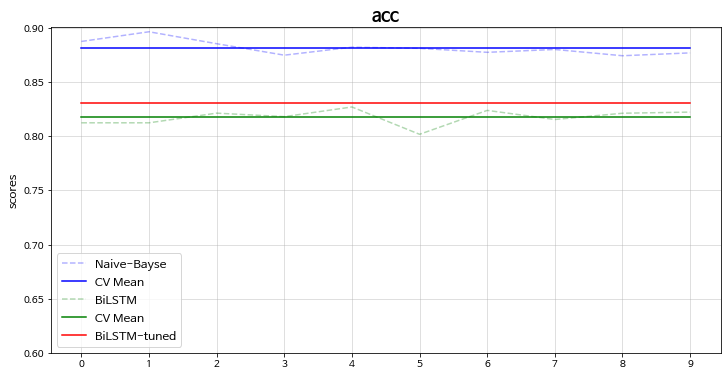

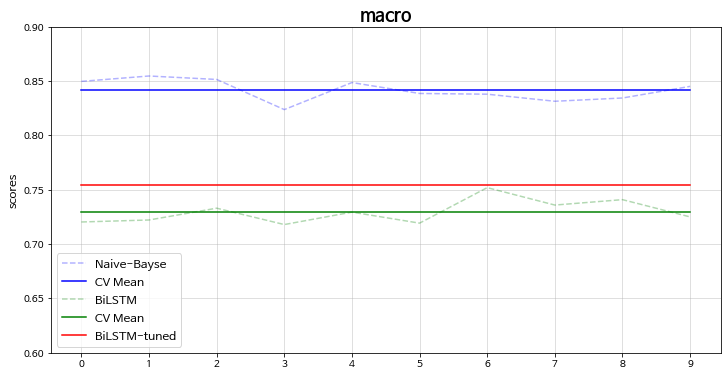

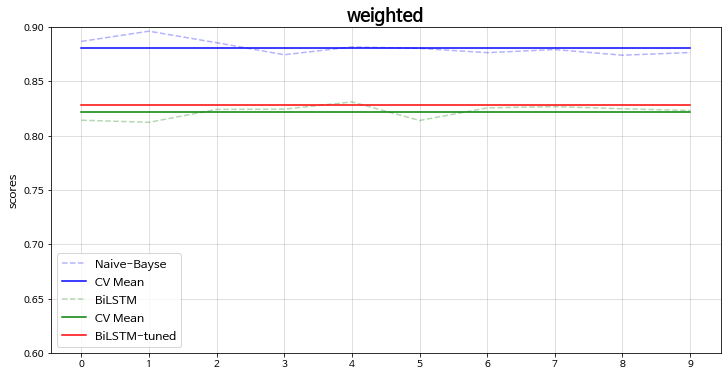

In [ ]:
metrics = ['acc', 'macro', 'weighted']
for m in metrics:
    scoring_plot(m)
    print('='*100)

# Usage Flow Example

## pororo summarizer

In [11]:
# pororo summarization method
get_summary_abs = Pororo(task='summary', lang='kr', model='abstractive')
get_summary_ext = Pororo(task='summary', lang='kr', model='extractive')

## news-crwawler

In [1]:
def rknews_crwaler(n_news):
    print('Îâ¥Ïä§Î•º Í∞ÄÏ†∏Ïò§Îäî Ï§ëÏûÖÎãàÎã§...')
    # n_news: Î∂àÎü¨ Ïò¨ Îâ¥Ïä§ Í∏∞ÏÇ¨ Ïàò
    base_url= "https://news.naver.com/main/ranking/popularDay.nhn?mid=etc&sid1=111"
    headers = {'User-Agent': 'Mozilla/5.0'} # 403ÏóêÎü¨Í∞Ä Îú∞ Îïå Ìó§ÎçîÎ•º Ï∂îÍ∞ÄÌï¥Ï£ºÎ©¥ Ï†ëÍ∑ºÌï† Ïàò ÏûàÏùå
    response = requests.get(base_url, headers=headers)

    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
    else : 
        print(response.status_code)

    news_url_lst = []

    info = soup.findAll('div', {'class': 'list_content'})
    for each in info:
        each_news = each.findAll('a', {'class': "list_title nclicks('RBP.rnknws')"})
        news_url = 'https://news.naver.com/' + each_news[0].get('href')
        news_url_lst.append(news_url)

    text_lst = []

    for news_url in news_url_lst[:n_news]: # ÌÅ¨Î°§ÎßÅÌï¥Ïò¨ Îâ¥Ïä§ Í∞úÏàò
        res_article= requests.get(news_url, headers=headers)

        if res_article.status_code == 200:
            html_article = res_article.text
            soup_article = BeautifulSoup(html_article, 'html.parser')
        else : 
            print(res_article.status_code)

        text = soup_article.findAll('div', {'class':'_article_body_contents'})[0].text

        if text == []:
            continue

        # if '‚ñ∂' in text:
        #     try:
        #         text = text.split('‚ñ∂')[:-5][0]
        #     except IndexError:
        #         pass

        text = ' '.join(text.split('\n')[8:])
        text = '.'.join(text.split('.')[:-2])
        text_lst.append(text)
    
    print(f'Ïã§ÏãúÍ∞Ñ Îû≠ÌÇπ Îâ¥Ïä§ {len(text_lst)}Í∞úÎ•º Í∞ÄÏ†∏ÏôîÏäµÎãàÎã§.')
    return text_lst

## Cleaning

In [2]:
def get_cleaning_lst(texts):

    print('ÌÖçÏä§Ìä∏Î•º Ï†ïÏ†úÏ§ëÏûÖÎãàÎã§...')
    def text_cleaning_get_tokens(text):

        mecab = Mecab()

        def text_preprocessing(txt):
            find_email = '[a-zA-Z0-9]+[\._]?[a-z0-9]+[@]+[a-zA-Z0-9]'
            get_email = re.search(find_email, txt)
            if get_email:
                txt = txt[:get_email.start()] + txt[get_email.end():]
            txt = re.sub('[^Í∞Ä-Ìû£a-zA-Z ]', '', txt)
            txt = re.sub('[ ]+', ' ', txt)
            remove_msg = re.search('flash Ïò§Î•òÎ•º Ïö∞ÌöåÌïòÍ∏∞ ÏúÑÌïú Ìï®Ïàò Ï∂îÍ∞Ä function flashremoveCallback', txt)
            if remove_msg != None:
                txt = txt[:remove_msg.start()] + txt[remove_msg.end():]
            remove_msg = re.search('ÏΩîÎ°úÎÇò ÌòÑÌô© ÏÜçÎ≥¥ Í∞ÄÏû• ÌôïÏã§Ìïú SBS Ï†úÎ≥¥ ÌÅ¥Î¶≠ Ï†úÎ≥¥ÌïòÍ∏∞', txt)
            if remove_msg != None:
                txt = txt[:remove_msg.start()] + txt[remove_msg.end():]
            txt = txt.replace('ÏïµÏª§', '')

            txt = txt.strip()
            return txt

        def text_to_morphs(txt, tokenizer=mecab):
            stop_words = pd.read_csv('ÌïúÍµ≠Ïñ¥Î∂àÏö©Ïñ¥100.txt', sep='\t', header=None)
            stop_words = stop_words[0].tolist()
            add_stop_words = ['ÏóêÏÑú', 'Ïùò', 'ÏùÑ', 'Î•º', 'Ïù¥', 'Í∞Ä', 'Îäî', 'ÏùÄ', 'search', 'Ïóê', 'ÏïµÏª§', 'Í∏∞Ïûê']
            for word in add_stop_words:
                stop_words.append(word)
            stop_words = list(set(stop_words))

            morphs = tokenizer.morphs(txt)
            tokens = [m for m in morphs if m not in stop_words]
            return tokens

        text = text_preprocessing(text)
        tokens = text_to_morphs(text)

        return text, tokens


    tokens_lst = []
    clean_text_lst = []
    abs_summary_lst = []
    ext_summary_lst = []
    
    for text in texts:
        clean_text, tokens = text_cleaning_get_tokens(text)
        tokens_lst.append(tokens)
        clean_text_lst.append(clean_text)
        abs_summary_lst.append(get_summary_abs(clean_text))
        ext_summary_lst.append(get_summary_ext(clean_text))
    
    return tokens_lst, clean_text_lst, abs_summary_lst, ext_summary_lst

## Models

In [3]:
### NB model create
    
# tfidf vectorizer load
def identify_tokenizer(text):
    return text

# vectorizer = pickle.load(open('tfidf.pickle', 'rb')) # Ï†ÄÏû•Ìïú Î≤°ÌÑ∞ÎùºÏù¥Ï†∏Ïóê ÏÇ¨Ïö©Îêú Ìï®ÏàòÍ∞Ä ÏûàÏñ¥Ïïº Î∂àÎü¨Ïò¨ Ïàò ÏûàÏùå

# X = vectorizer.transform(tokens_lst)

def create_NB_model():
    model = joblib.load('nb_clf_model.pkl')
    return model

# NB_clf = create_NB_model()

In [4]:
## BiLSTM model create
max_features = 512818
embedding_dim = 128
maxlen = 1917

# ÌäúÎãùÎ™®Îç∏Ïùò ÌïôÏäµ Í∞ÄÏ§ëÏπòÎ•º Î∂àÎü¨ÏôÄÏÑú Î™®Îç∏ Ï†ïÏùòÌï† Îïå ÏÇ¨Ïö©Ìï† Ïàò ÏûàÎäî Î™®Îç∏ ÏÉùÏÑ± Ìï®Ïàò
def create_tuner_model():
    

    model = Sequential()
    
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(SpatialDropout1D(0.3))

    model.add(Bidirectional(LSTM(160, return_sequences=True, kernel_regularizer=regularizers.l2(1e-06))))
    model.add(Bidirectional(LSTM(160)))

    model.add(Dropout(0.4))
    model.add(Dense(448, activation='tanh', kernel_regularizer=regularizers.l2(1e-06)))

    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# # load tokenizer
# tokenizer = pickle.load(open('tokenizer.pickle', 'rb'))
# # text data -> encoded data -> padding data
# X_encoded = tokenizer.texts_to_sequences(clean_text_lst)
# X_padding = pad_sequences(X_encoded, maxlen=maxlen)
# # load model weights
# BiLSTM_clf = create_tuner_model()
# BiLSTM_clf.load_weights('BiLSTM-weights-best-usingAugumentation-kerastuner.hdf5')

In [31]:
# # naive-bayse category prediction
# pred_class_lst_nb = NB_clf.predict(X)
# pred_proba_lst_nb = [max(x) for x in NB_clf.predict_proba(X)]

# # bilstm categoty prediction
# pred_bi = BiLSTM_clf.predict(X_padding)
# pred_proba_lst_bi = [max(x) for x in pred_bi]
# pred_class_lst_bi = np.argmax(pred_bi, axis=1)

## Result

In [5]:
def show_result(model, summarizer, texts,
                pred_class_lst_nb, pred_proba_lst_nb,
                pred_class_lst_bi, pred_proba_lst_bi,
                abs_summary_lst, ext_summary_lst):
    
    category_dict = {0:'ÏÉùÌôú/Î¨∏Ìôî',
                     1:'Ï†ïÏπò/ÏÇ¨Ìöå',
                     2:'Í≤ΩÏ†ú/ÏÇ∞ÏóÖ',
                     3:'Í≥ºÌïô/Í±¥Í∞ï'}

    def print_by_length(text):
        '''
        ÏΩîÎû© ÎÖ∏Ìä∏Î∂ÅÏóêÏÑú print()ÌïòÎ©¥ ÌÖçÏä§Ìä∏Í∞Ä 1Ïó¥Î°ú ÎÇòÏôÄÏÑú Í∞ÄÎèÖÏÑ±Ïù¥ ÏïàÏ¢ãÏùå
        ÌÖçÏä§Ìä∏ Í∏∏Ïù¥ 100ÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÏûòÎùºÏÑú Ï∂úÎ†•Ìï¥Ï£ºÎäî Ìï®Ïàò Íµ¨ÌòÑ
        '''
        if len(text) > 100:    
            start = 0
            end = 100
            for _ in range(1, int(len(text) / 100)+2):
                print(text[start:end])
                start = end
                end += 100
        else:
            print(text)


    for i in range(len(texts)):
        print('[Original:]')
        print_by_length(texts[i])
        print('\n')

        print('[Category:]')
        if model == 'Naive-Bayes':
            # print('Naive-Bayse Classifier =>')
            print(f'{category_dict[pred_class_lst_nb[i]]} in {round(pred_proba_lst_nb[i]*100, 2)}%',)
        if model == 'BiLSTM':
            # print('BiLSTM Classifier => ')
            print(f'{category_dict[pred_class_lst_bi[i]]} in {round(pred_proba_lst_bi[i]*100, 2)}%')
        print('\n')

        print('[Summarization:]')
        if summarizer == 'Abstractive':
            # print('Abstraction =>')
            print_by_length(abs_summary_lst[i])
        if summarizer == 'Extractive':
            # print('Extraction =>')
            print_by_length(ext_summary_lst[i])
        print('\n')

        print('='*150, '\n')

In [6]:
from ipywidgets import widgets
from IPython.display import display, clear_output
#https://ichi.pro/ko/jupyter-wijes-eul-hwal-yong-han-jadonghwa-doen-yecheug-jeobgeun-bangsig-22176733451028

In [7]:
def widget():
    # widgets buttons
    models = ('Naive-Bayes', 'BiLSTM')
    summarizers = ('Abstractive', 'Extractive')
   
    newsnum = widgets.BoundedIntText(value=5, min=1, max=10, step=1, description='Article cnt', disabled=False, layout=widgets.Layout(width='25%', height='40px'))                         
    model_select = widgets.Dropdown(options=models, description='Classifier', layout=widgets.Layout(width='25%', height='40px'))
    summarizer_select = widgets.Dropdown(options=summarizers, description='Summarizer', layout=widgets.Layout(width='25%', height='40px'))
    getnews = widgets.Button(description='Check Ranking News', layout=widgets.Layout(width='25%', height='80px'))
    output = widgets.Output()
    clear = widgets.Button(description='Clear all', layout=widgets.Layout(width='25%', height='40px'))
    
    def getnews_click(b):
        texts = rknews_crwaler(newsnum.value)
        tokens_lst, clean_text_lst, abs_summary_lst, ext_summary_lst = get_cleaning_lst(texts)
        
        print('Í∏∞ÏÇ¨Î•º ÏöîÏïΩÏ§ëÏûÖÎãàÎã§. Ïû†ÏãúÎßå Í∏∞Îã§Î†§Ï£ºÏÑ∏Ïöî!')
        
        vectorizer = pickle.load(open('tfidf.pickle', 'rb'))
        X = vectorizer.transform(tokens_lst)
        NB_clf = create_NB_model()
        
        tokenizer = pickle.load(open('tokenizer.pickle', 'rb'))
        X_encoded = tokenizer.texts_to_sequences(clean_text_lst)
        X_padding = pad_sequences(X_encoded, maxlen=maxlen)
        BiLSTM_clf = create_tuner_model()
        BiLSTM_clf.load_weights('BiLSTM-weights-best-usingAugumentation-kerastuner.hdf5')

        pred_class_lst_nb = NB_clf.predict(X)
        pred_proba_lst_nb = [max(x) for x in NB_clf.predict_proba(X)]
        pred_bi = BiLSTM_clf.predict(X_padding)
        pred_proba_lst_bi = [max(x) for x in pred_bi]
        pred_class_lst_bi = np.argmax(pred_bi, axis=1)
    
        model = model_select.value
        summarizer = summarizer_select.value

        with output:
            clear_output()
            show_result(model, summarizer, texts,
                        pred_class_lst_nb, pred_proba_lst_nb,
                        pred_class_lst_bi, pred_proba_lst_bi,
                        abs_summary_lst, ext_summary_lst)


    def clear_all(b):
        with output:
            clear_output()
            print('='*150)
            

    display(newsnum, model_select, summarizer_select, getnews, clear, output)
    getnews.on_click(getnews_click)
    clear.on_click(clear_all)

In [12]:
widget()

BoundedIntText(value=5, description='Article cnt', layout=Layout(height='40px', width='25%'), max=10, min=1)

Dropdown(description='Classifier', layout=Layout(height='40px', width='25%'), options=('Naive-Bayes', 'BiLSTM'‚Ä¶

Dropdown(description='Summarizer', layout=Layout(height='40px', width='25%'), options=('Abstractive', 'Extract‚Ä¶

Button(description='Check Ranking News', layout=Layout(height='80px', width='25%'), style=ButtonStyle())

Button(description='Clear all', layout=Layout(height='40px', width='25%'), style=ButtonStyle())

Output()

Îâ¥Ïä§Î•º Í∞ÄÏ†∏Ïò§Îäî Ï§ëÏûÖÎãàÎã§...
Ïã§ÏãúÍ∞Ñ Îû≠ÌÇπ Îâ¥Ïä§ 5Í∞úÎ•º Í∞ÄÏ†∏ÏôîÏäµÎãàÎã§.
ÌÖçÏä§Ìä∏Î•º Ï†ïÏ†úÏ§ëÏûÖÎãàÎã§...
Í∏∞ÏÇ¨Î•º ÏöîÏïΩÏ§ëÏûÖÎãàÎã§. Ïû†ÏãúÎßå Í∏∞Îã§Î†§Ï£ºÏÑ∏Ïöî!
